In [250]:
import os.path
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from gensim.downloader import load
import gensim
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist #used to determine number of tokens
from gensim.models import Word2Vec

In [251]:
with open("goemotions.json", "r") as read_content:
    file = pd.read_json(read_content)

Taking count of all sentiment and emotion tags respectively associated with Reddit posts. Then creating a dictionary to create key-value pairings.

In [252]:
print(file.loc[file[0]=='They have THE BEST tortillas too. Made right in front of you. Mmmmmm!'])

                                                        0           1  \
264     They have THE BEST tortillas too. Made right i...     neutral   
23540   They have THE BEST tortillas too. Made right i...     neutral   
73369   They have THE BEST tortillas too. Made right i...  admiration   
86008   They have THE BEST tortillas too. Made right i...  admiration   
115605  They have THE BEST tortillas too. Made right i...    approval   

               2  
264      neutral  
23540    neutral  
73369   positive  
86008   positive  
115605  positive  


In [253]:
sentiment = file[2].value_counts().to_dict()
sentiment_values = sentiment.keys()
sentiment_frequency = sentiment.values()

In [254]:
emotion = file[1].value_counts().to_dict()
emotion_values = emotion.keys()
emotion_frequency = emotion.values()

In [255]:
# print(emotion)
# emotion_list = list(emotion_frequency)
# pdP = pd.Series(emotion_list)
# print(pdP.describe())

In [256]:
# print(sentiment)
# sentiment_list = list(sentiment_frequency)
# pdP = pd.Series(sentiment_list) 
# print(pdP.describe())

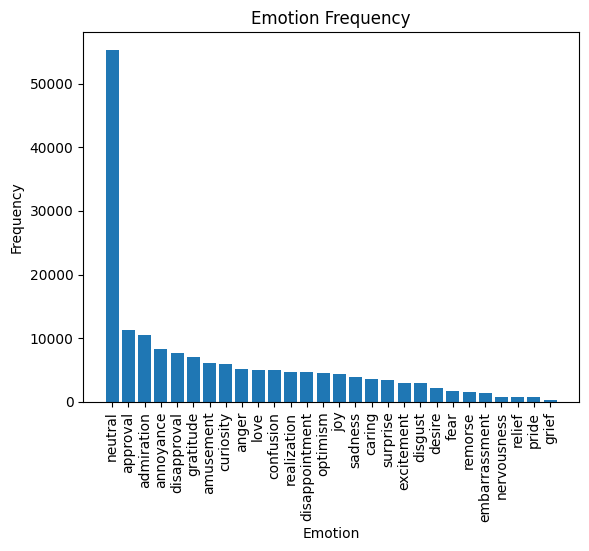

In [257]:
plt.xlabel("Emotion")
plt.ylabel("Frequency")
plt.title("Emotion Frequency")
plt.xticks(rotation= 90) #done for readbility purposes
plt.bar(emotion_values, emotion_frequency)
plt.savefig("bar_emotion.png")
plt.show()

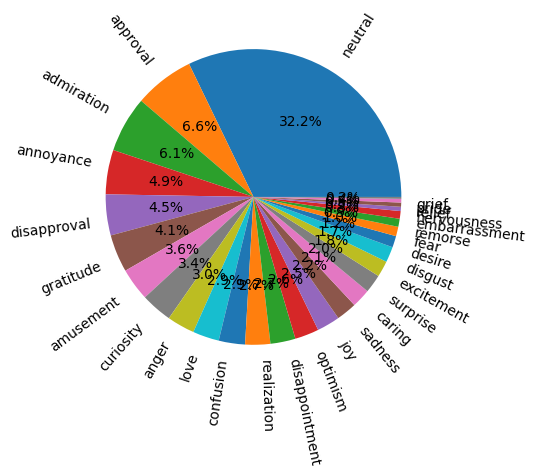

In [258]:
emotionLabels = []
sizes = []
for x, y in emotion.items():
    emotionLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=emotionLabels, rotatelabels = True, autopct ='%1.1f%%')
plt.savefig("pie_emotion.png")
plt.show()


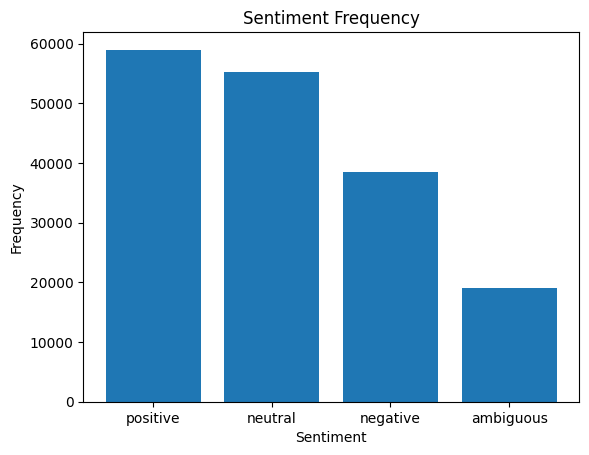

In [259]:
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.title("Sentiment Frequency")
plt.bar(sentiment_values, sentiment_frequency)
plt.savefig("bar_sentiment.png")
plt.show()

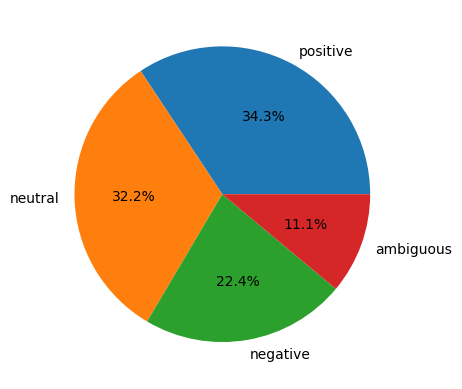

In [260]:
sentimentLabels = []
sizes = []
for x, y in sentiment.items():
    sentimentLabels.append(x)
    sizes.append(y)
plt.pie(sizes, labels=sentimentLabels, autopct ='%1.1f%%')
plt.savefig("pie_sentiment.png")
plt.show()


Plotting of Frequency vs. Emotion and Frequency vs. Sentiment <br>
Source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html <br>
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html

<h1>extract tokens/words</h1>

In [261]:
post = file[0].tolist()
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(post)
# vectorizer.get_feature_names_out()

In [262]:
#print(f"The number of unique words is {len(X.toarray()[0])} unique words")

Given that when X.toarray() is used, the occurrences of words in a post is counted for example <br> "This document is the second document."<br> the word document is used twice [0 2 0 1 0 1 1 0 1] mapping to the array of unique words ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
<br>
Sources: <br>
https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [263]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1]) #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2]) #change 0 to the column of sentiment with no separation

<h2>2.2 Training and Test data split</h2>

In [264]:
#Question 2.2
X_train,X_test,yemo_train, yemo_test,ysent_train, ysent_test = train_test_split(X,encodedEmo,encodedSentiment, test_size = 0.2, train_size=0.8)

In [265]:
print(len(yemo_train))

137456


In [266]:
def metrics(true_y,prediction_y):
    print(f"Accuracy: {accuracy_score(y_true=true_y,y_pred= prediction_y)}")
    print(f"Precision (Weighted): {precision_score(y_true=true_y,y_pred= prediction_y, average='weighted')}")
    print(f"F1 Score (Weighted): {f1_score(y_true=true_y,y_pred= prediction_y,average='weighted')}")
    print(f"F1 Score (Macro): {f1_score(y_true=true_y,y_pred= prediction_y,average='macro')}")
    print(classification_report(y_true=true_y,y_pred= prediction_y, zero_division='warn'))
    confusion_matrix(y_true=true_y,y_pred= prediction_y)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html)
with the default parameters.</h2>

Source: https://www.delftstack.com/howto/python/how-to-get-dictionary-keys-as-a-list-in-python/

In [267]:
classifier = MultinomialNB()
if (os.path.exists('models/MNB1_model.pickle')):
    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2_model.pickle')):
    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.4336514957513677
Accuracy: 0.4336514957513677
Precision (Weighted): 0.48266003509405797
F1 Score (Weighted): 0.36579069700670575
F1 Score (Macro): 0.22197215372725704
              precision    recall  f1-score   support

           0       0.55      0.52      0.53      2069
           1       0.62      0.36      0.45      1187
           2       0.50      0.18      0.27      1024
           3       0.37      0.12      0.19      1697
           4       0.44      0.16      0.24      2273
           5       0.44      0.09      0.15       754
           6       0.49      0.09      0.15       976
           7       0.58      0.18      0.27      1228
           8       0.74      0.08      0.14       395
           9       0.46      0.07      0.12       932
          10       0.46      0.16      0.23      1504
          11       0.66      0.13      0.21       582
          12       0.80      0.03      0.05       295
          13       0.49      0.06      0.11       564
 

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

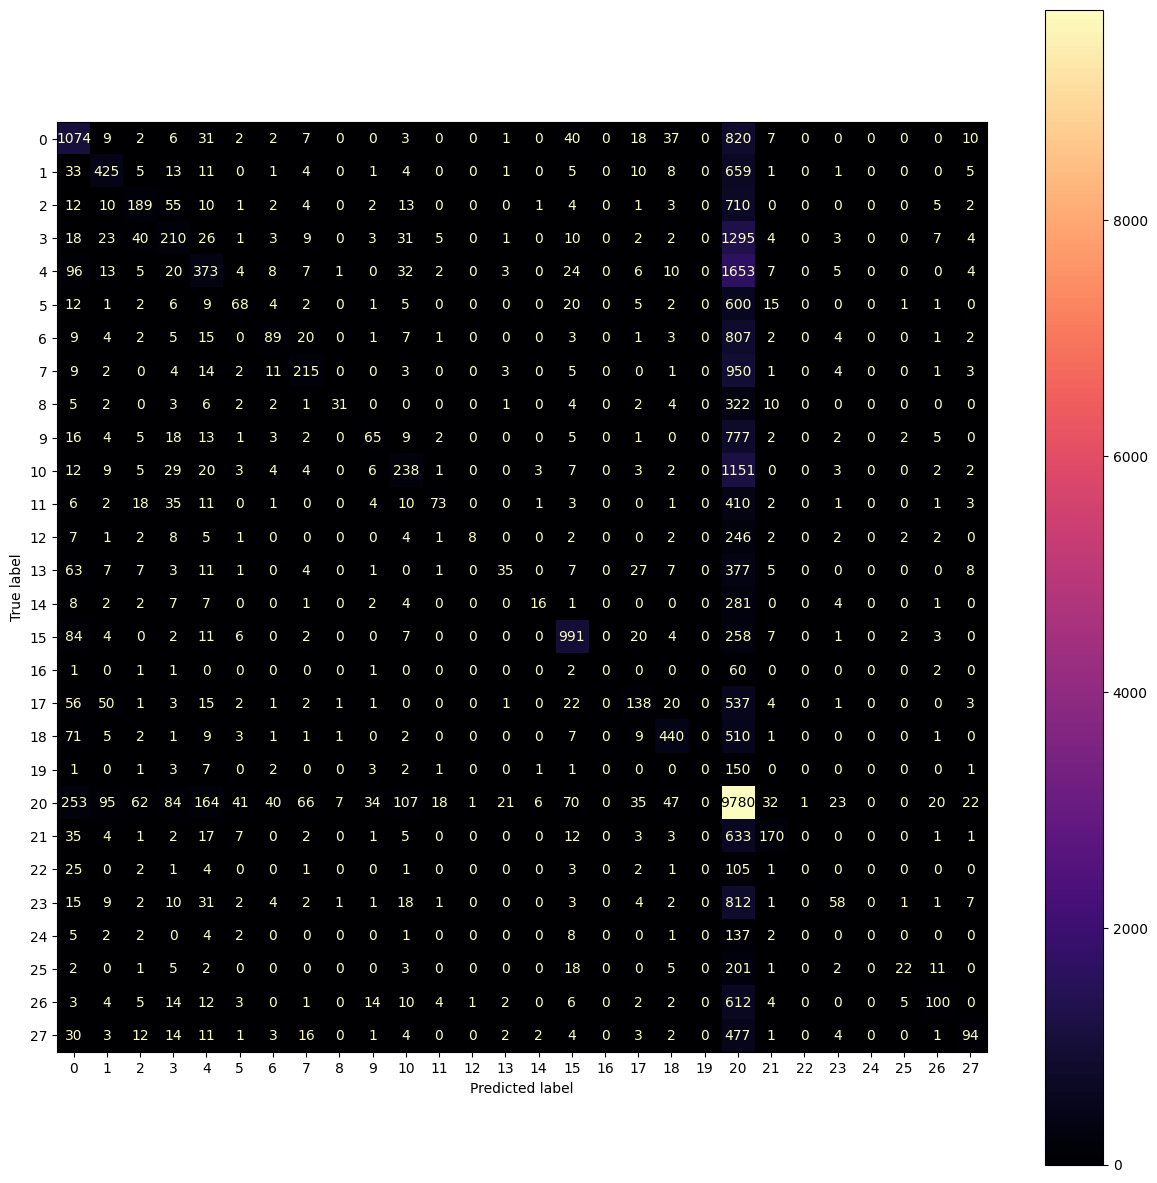

In [268]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.6071761145384705
Accuracy: 0.6071761145384705
Precision (Weighted): 0.6027865497336333
F1 Score (Weighted): 0.6006625303978792
F1 Score (Macro): 0.5681413607526333
              precision    recall  f1-score   support

           0       0.56      0.33      0.41      3874
           1       0.60      0.60      0.60      7688
           2       0.56      0.57      0.56     11029
           3       0.66      0.75      0.70     11773

    accuracy                           0.61     34364
   macro avg       0.59      0.56      0.57     34364
weighted avg       0.60      0.61      0.60     34364



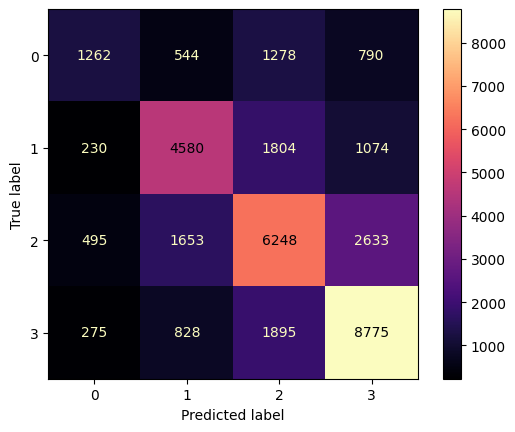

In [269]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>cross validation</h2>
<body>from sklearn.model_selection import cross_val_score</body>

<h2>Decision Tree (tree.DecisionTreeClassifier) with the default parameters.</h2>

In [270]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/DT1_model.pickle')):
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)


if (os.path.exists('models/DT2_model.pickle')):

    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/DT2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotion: 0.5952159236410197
Accuracy: 0.5952159236410197
Precision (Weighted): 0.6136767811042175
F1 Score (Weighted): 0.5924062242586289
F1 Score (Macro): 0.518202598555523
              precision    recall  f1-score   support

           0       0.57      0.82      0.67      2069
           1       0.57      0.82      0.67      1187
           2       0.44      0.71      0.54      1024
           3       0.40      0.58      0.47      1697
           4       0.47      0.57      0.51      2273
           5       0.48      0.55      0.52       754
           6       0.46      0.55      0.50       976
           7       0.58      0.63      0.60      1228
           8       0.47      0.52      0.50       395
           9       0.46      0.46      0.46       932
          10       0.53      0.49      0.51      1504
          11       0.55      0.43      0.48       582
          12       0.54      0.44      0.49       295
          13       0.48      0.41      0.45       564
     

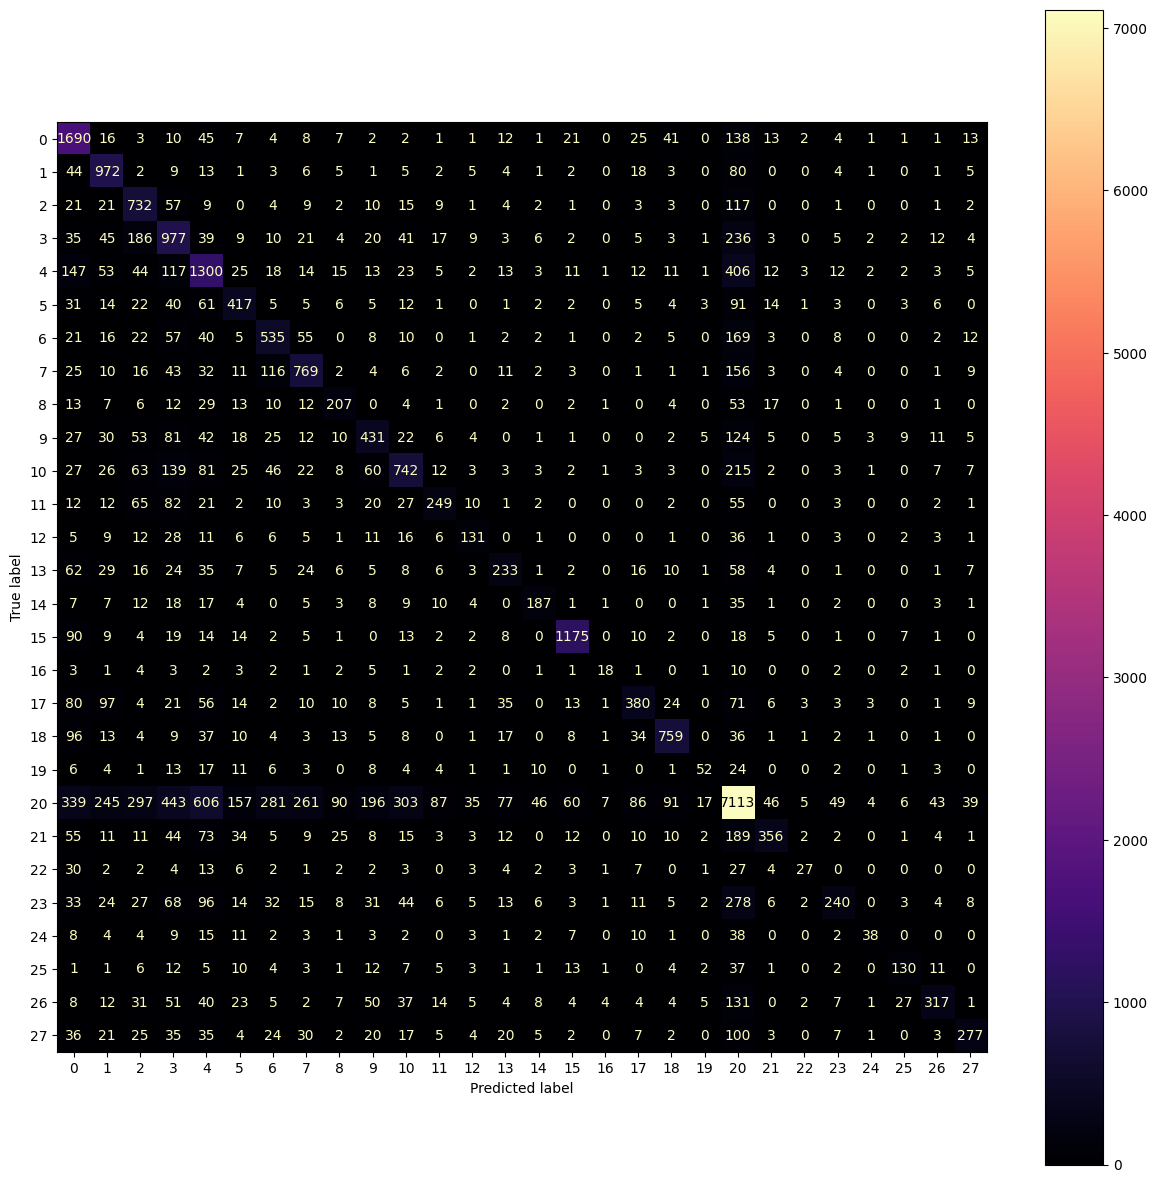

In [271]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')


Score for Sentiment: 0.7171167500873007
Accuracy: 0.7171167500873007
Precision (Weighted): 0.7282310722868622
F1 Score (Weighted): 0.719464879967777
F1 Score (Macro): 0.7035922998177495
              precision    recall  f1-score   support

           0       0.56      0.71      0.63      3874
           1       0.67      0.77      0.72      7688
           2       0.71      0.66      0.69     11029
           3       0.84      0.73      0.78     11773

    accuracy                           0.72     34364
   macro avg       0.70      0.72      0.70     34364
weighted avg       0.73      0.72      0.72     34364



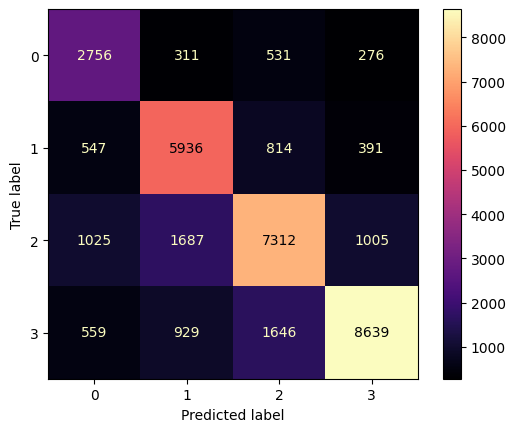

In [272]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) with the default parameters.</h2>

In [273]:
classifier = MLPClassifier()
if (os.path.exists('models/MLP1_model.pickle')):
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP1 = classifier.fit(X_train, yemo_train)
    with open('models/MLP1_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP1_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MLP2_model.pickle')):
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    MLP2 = classifier.fit(X_train,ysent_train)
    with open('models/MLP2_model.pickle','wb') as f:
            pickle.dump(classifier, f)
    pickle_in = open('models/MLP2_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


pickle file used
pickle file used


In [274]:
print(np.shape(X_train))
print(np.shape(yemo_train))

(137456, 30449)
(137456,)


Score for Emotion: 0.5774356885112327
Accuracy: 0.5774356885112327
Precision (Weighted): 0.5713244077653047
F1 Score (Weighted): 0.5717176630808645
F1 Score (Macro): 0.5082338903724558
              precision    recall  f1-score   support

           0       0.64      0.67      0.65      2069
           1       0.64      0.68      0.66      1187
           2       0.51      0.53      0.52      1024
           3       0.46      0.40      0.43      1697
           4       0.49      0.39      0.43      2273
           5       0.49      0.45      0.47       754
           6       0.48      0.44      0.46       976
           7       0.59      0.49      0.54      1228
           8       0.42      0.56      0.48       395
           9       0.42      0.38      0.40       932
          10       0.47      0.49      0.48      1504
          11       0.50      0.45      0.47       582
          12       0.45      0.46      0.45       295
          13       0.44      0.41      0.42       564
    

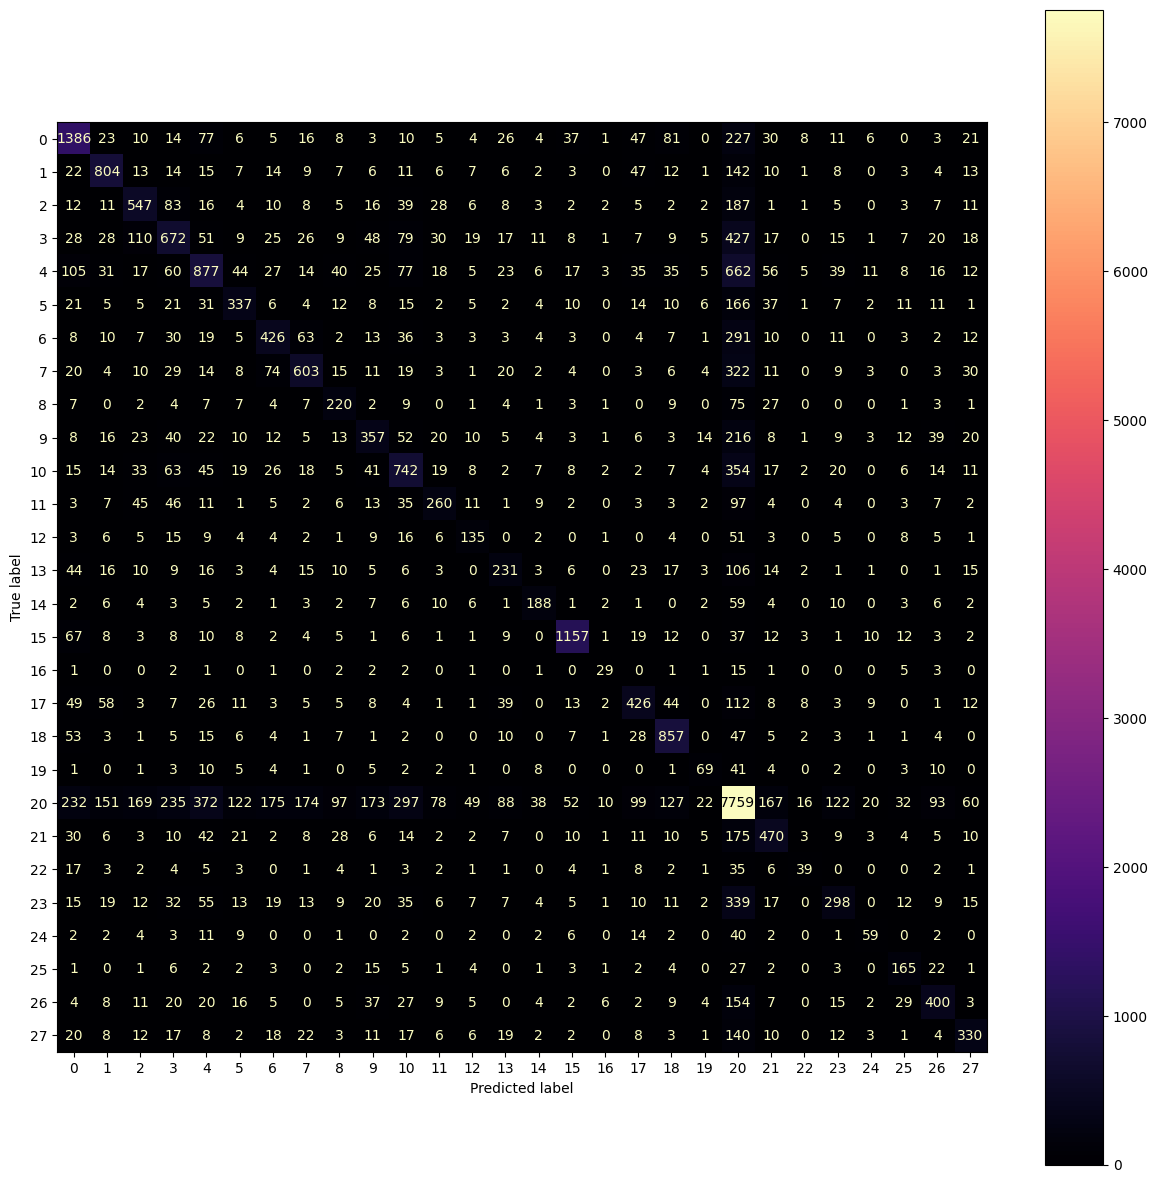

In [275]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test,yemo_test)}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Score for Sentiment: 0.5563089279478524
Accuracy: 0.5563089279478524
Precision (Weighted): 0.565125203925253
F1 Score (Weighted): 0.5410085766935441
F1 Score (Macro): 0.4831444317564948
              precision    recall  f1-score   support

           0       0.55      0.13      0.21      3874
           1       0.56      0.46      0.50      7688
           2       0.47      0.64      0.54     11029
           3       0.66      0.68      0.67     11773

    accuracy                           0.56     34364
   macro avg       0.56      0.48      0.48     34364
weighted avg       0.57      0.56      0.54     34364



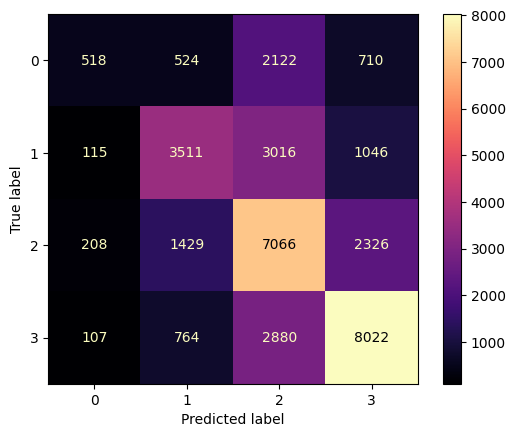

In [276]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test,ysent_test)}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1


In [277]:
parameters = {"alpha":(0.5,0,0.36,1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/MNB1GridCV_model.pickle')):
    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/MNB1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/MNB2GridCV_model.pickle')):
    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/MNB2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/MNB2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GridSearchCV from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


<h2>Decision Tree Classifier found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples


In [278]:
parameters = {"criterion":("gini","entropy"),"max_depth":(100,3),"min_samples_split":(12,5,30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters,n_jobs=-1)

if (os.path.exists('models/DT1GridCV_model.pickle')):
    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/DT1GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT1GridCV_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/DT2GridCV_model.pickle')):
    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train,ysent_train)
    with open('models/DT2GridCV_model.pickle','wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/DT2GridCV_model.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.4044639513068846
Accuracy: 0.5051798393667792
Precision (Weighted): 0.5099962057924216
F1 Score (Weighted): 0.4642977760618833
F1 Score (Macro): 0.3672330257199499
              precision    recall  f1-score   support

           0       0.58      0.56      0.57      2069
           1       0.59      0.67      0.62      1187
           2       0.47      0.34      0.39      1024
           3       0.38      0.20      0.26      1697
           4       0.41      0.18      0.25      2273
           5       0.46      0.21      0.29       754
           6       0.47      0.25      0.33       976
           7       0.54      0.27      0.36      1228
           8       0.43      0.25      0.32       395
           9       0.42      0.16      0.23       932
          10       0.45      0.23      0.31      1504
          11       0.59      0.28      0.38       582
          12       0.53      0.1

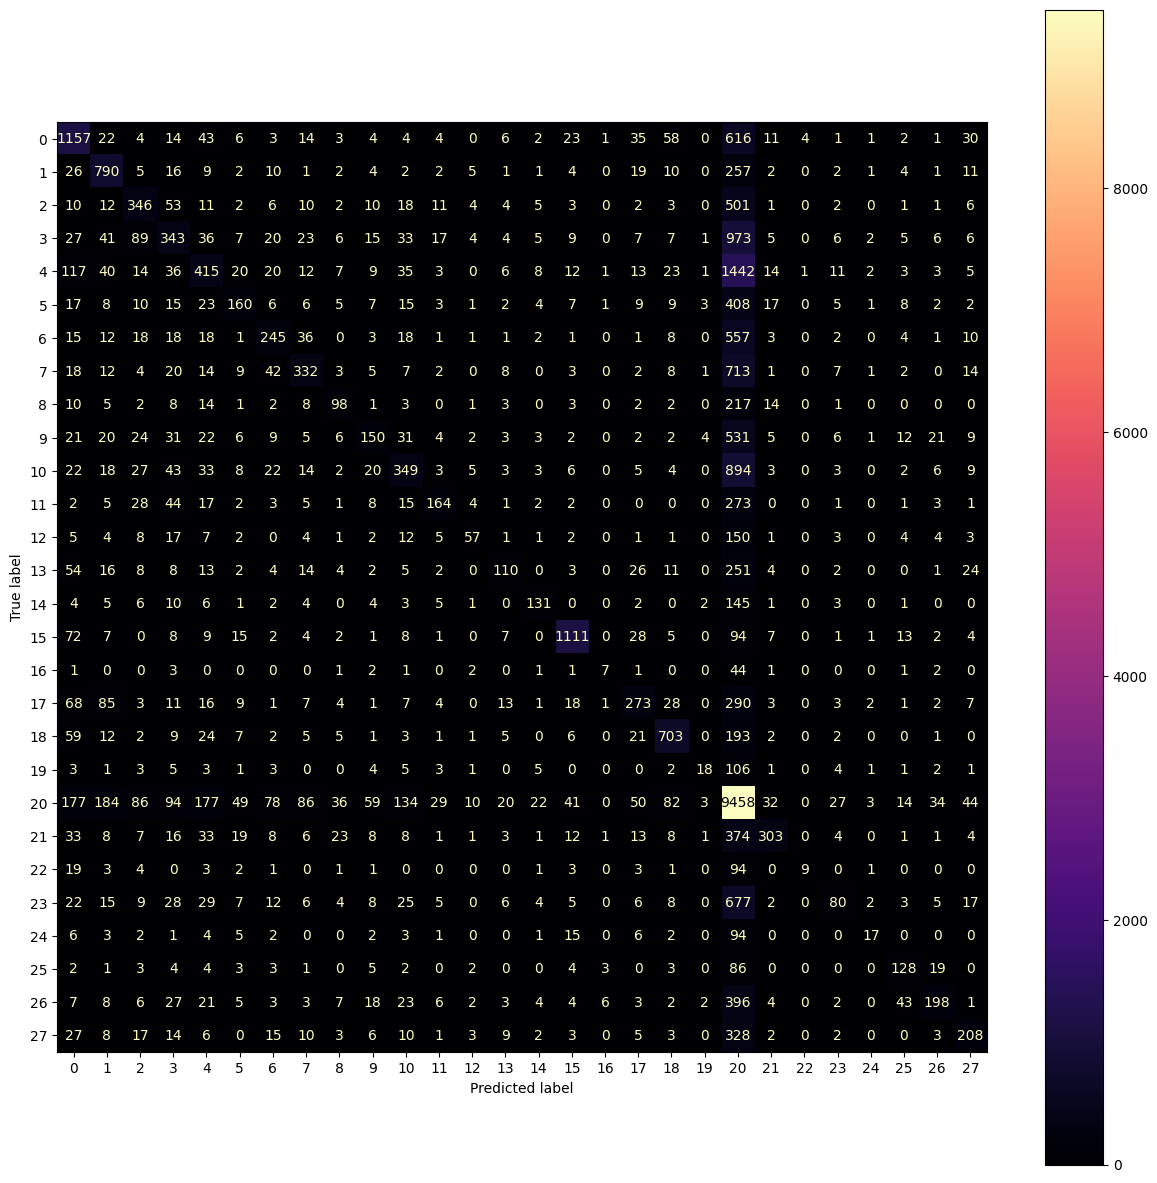

In [279]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test,y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax,cmap='magma')

Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.515219404662324
Accuracy: 0.6199220114072866
Precision (Weighted): 0.665171866270766
F1 Score (Weighted): 0.6215566239118451
F1 Score (Macro): 0.5958014990490659
              precision    recall  f1-score   support

           0       0.55      0.45      0.49      3874
           1       0.69      0.49      0.57      7688
           2       0.50      0.79      0.62     11029
           3       0.84      0.60      0.70     11773

    accuracy                           0.62     34364
   macro avg       0.64      0.58      0.60     34364
weighted avg       0.67      0.62      0.62     34364



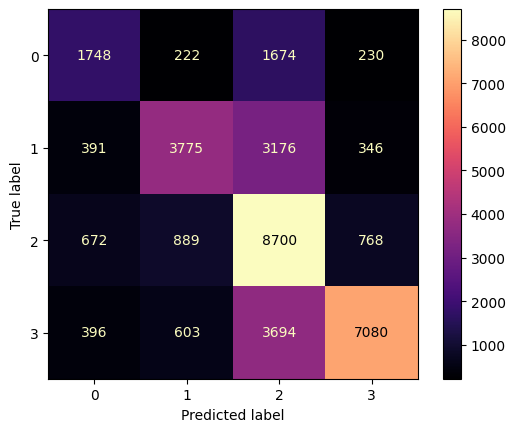

In [280]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test,y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [281]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True, verbose=True,max_iter=5)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters,n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/MLP1GridCV_model.pickle')):
        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/MLP1GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP1GridCV_model.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/MLP2GridCV_model.pickle')):
        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/MLP2GridCV_model.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/MLP2GridCV_model.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


Accuracy: 0.45666977069025727
Precision (Weighted): 0.44098903096032427
F1 Score (Weighted): 0.3776590659145878
F1 Score (Macro): 0.24318531908894755
              precision    recall  f1-score   support

           0       0.51      0.54      0.52      2069
           1       0.52      0.64      0.58      1187
           2       0.40      0.26      0.31      1024
           3       0.20      0.05      0.07      1697
           4       0.36      0.09      0.15      2273
           5       1.00      0.00      0.01       754
           6       0.46      0.12      0.19       976
           7       0.48      0.19      0.28      1228
           8       0.61      0.08      0.15       395
           9       0.20      0.00      0.00       932
          10       0.30      0.11      0.16      1504
          11       0.67      0.04      0.08       582
          12       0.75      0.01      0.02       295
          13       0.65      0.07      0.12       564
          14       0.52      0.38      

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

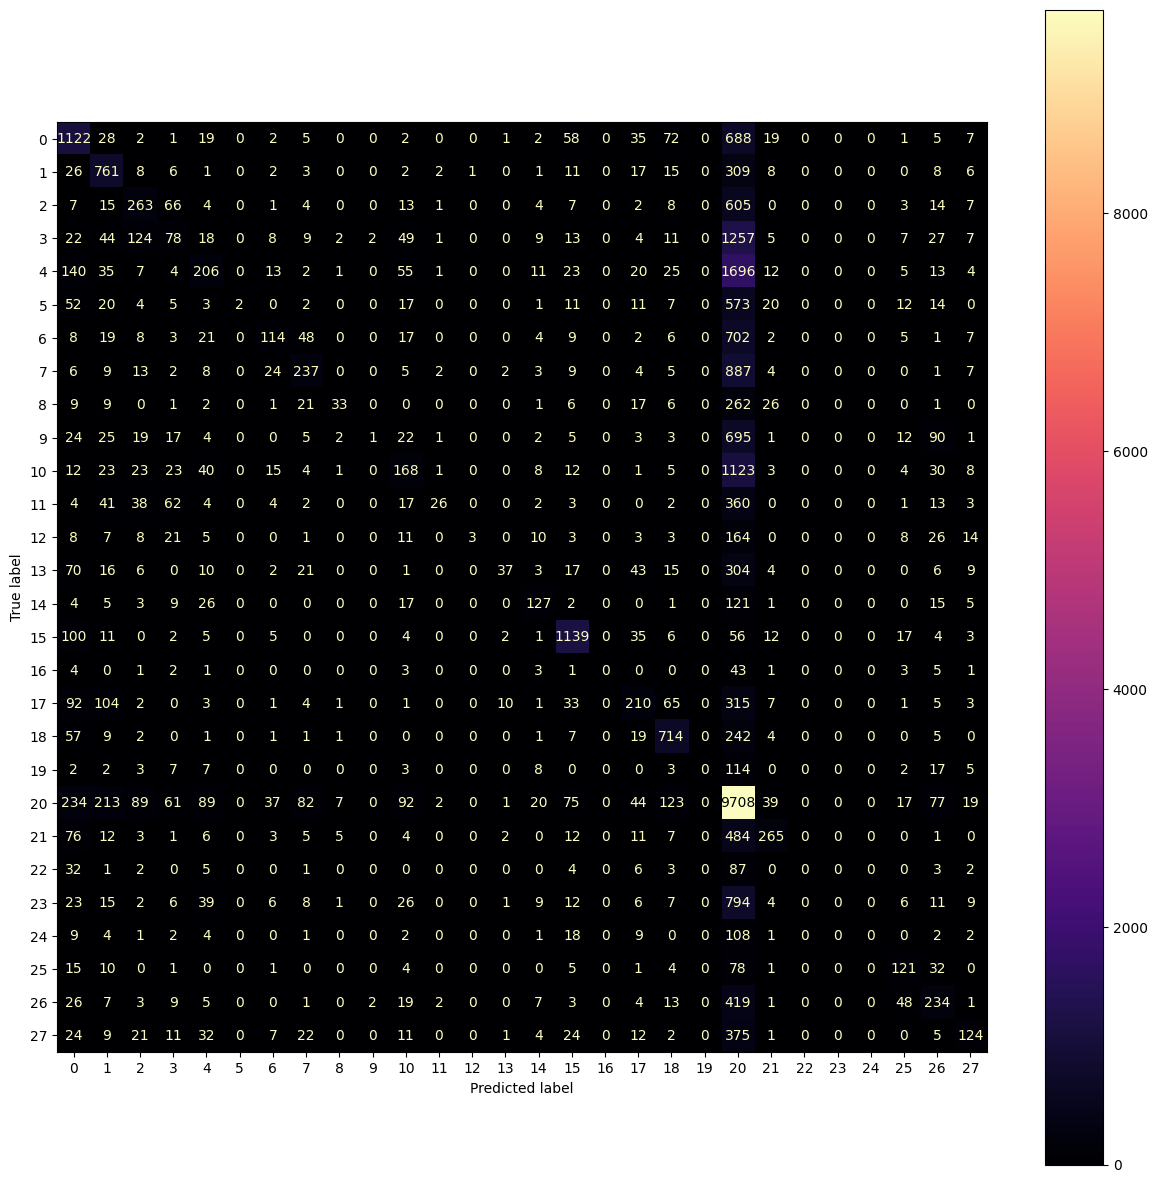

In [282]:
if (os.path.exists('models/MLP1GridCV_model.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

Accuracy: 0.6315038994296357
Precision (Weighted): 0.6309500655862549
F1 Score (Weighted): 0.6257694143225675
F1 Score (Macro): 0.5899643280321157
              precision    recall  f1-score   support

           0       0.60      0.33      0.42      3874
           1       0.63      0.59      0.61      7688
           2       0.56      0.63      0.60     11029
           3       0.71      0.75      0.73     11773

    accuracy                           0.63     34364
   macro avg       0.62      0.58      0.59     34364
weighted avg       0.63      0.63      0.63     34364

Best estimator (Sentiment): MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(5, 10), max_iter=5, verbose=True), Best Score: 0.5612705192148834


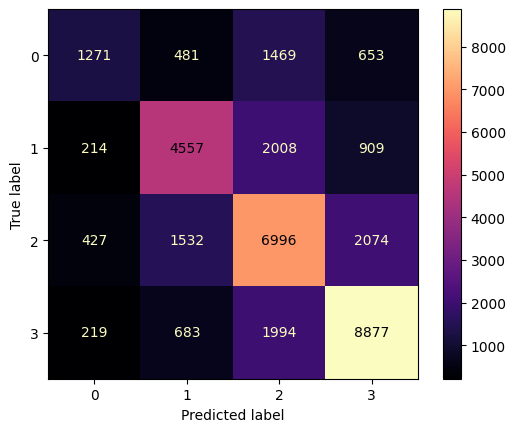

In [283]:
if (os.path.exists('models/MLP2GridCV_model.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h3>2.5</h3>
Test/Training split: 80/20 -> 50/50
Anticipated effect: increased accuracy but poor generalization


In [284]:
post = file[0]
vectorizer = CountVectorizer()
#vectorize posts into words that were used
# file[0] = vectorizer.fit_transform(post)
X = vectorizer.fit_transform(file[0])
# X_features =vectorizer.get_feature_names_out()

leEmo = preprocessing.LabelEncoder()
leSent = preprocessing.LabelEncoder()
#list(le.inverse_transform([2, 2, 1]))
encodedEmo = leEmo.fit_transform(file[1])  #change 0 to the column of emotions with no separation
#vectorize sentiments
encodedSentiment = leSent.fit_transform(file[2])  #change 0 to the column of sentiment with no separation



In [285]:
X_train, X_test, yemo_train, yemo_test, ysent_train, ysent_test = train_test_split(X, encodedEmo, encodedSentiment,test_size=0.5, train_size=0.5)

<h2>Multinomial Naive Bayes Classifier (naive bayes.MultinomialNB.html) using new test train split</h2>

In [286]:
classifier = MultinomialNB()
if (os.path.exists('models/new_split/MNB1_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")

else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.4503666627866372
Accuracy: 0.4503666627866372
Precision (Weighted): 0.4966836751117309
F1 Score (Weighted): 0.3912787129080495
F1 Score (Macro): 0.25189604294716317
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      5299
           1       0.61      0.42      0.50      2977
           2       0.53      0.21      0.30      2724
           3       0.40      0.16      0.23      4096
           4       0.47      0.19      0.27      5618
           5       0.44      0.13      0.21      1769
           6       0.53      0.13      0.20      2425
           7       0.57      0.20      0.30      2938
           8       0.64      0.09      0.15      1087
           9       0.50      0.10      0.16      2327
          10       0.44      0.17      0.24      3849
          11       0.58      0.14      0.23      1429
          12       0.63      0.04      0.07       701
          13       0.56      0.09      0.16      1553
   

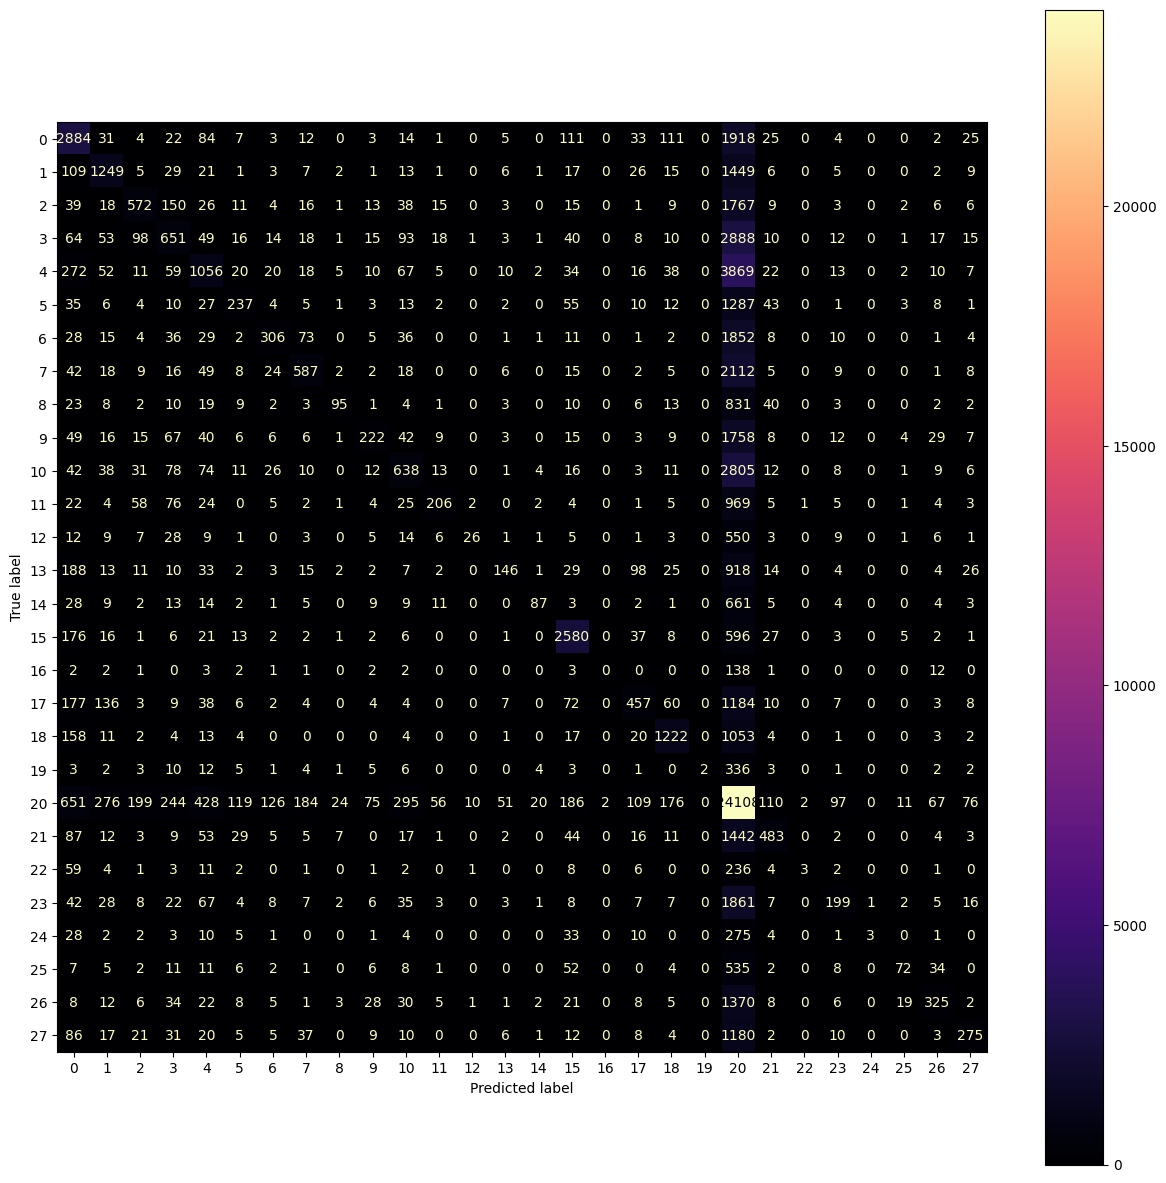

In [287]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.6143638691654056
Accuracy: 0.6143638691654056
Precision (Weighted): 0.6090678159377672
F1 Score (Weighted): 0.6083556905625425
F1 Score (Macro): 0.5757119974496441
              precision    recall  f1-score   support

           0       0.54      0.34      0.42      9454
           1       0.61      0.61      0.61     19272
           2       0.57      0.57      0.57     27702
           3       0.67      0.75      0.71     29482

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



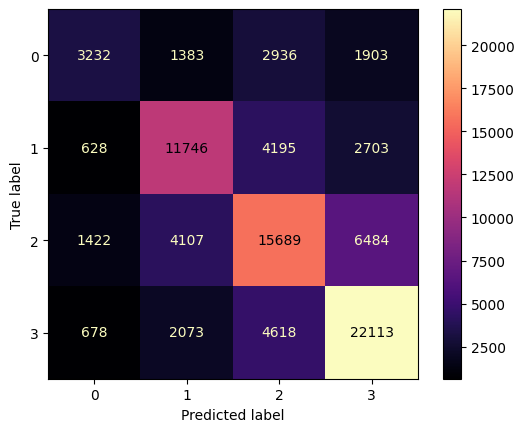

In [288]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Decision Tree (tree.DecisionTreeClassifier) using new test train split</h2>

In [289]:
classifier = DecisionTreeClassifier()
if (os.path.exists('models/new_split/DT1_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT1_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)
    pickle_in = open('models/new_split/DT2_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotion: 0.6209172389710161
Accuracy: 0.6209172389710161
Precision (Weighted): 0.6313749203610625
F1 Score (Weighted): 0.6156736262367276
F1 Score (Macro): 0.5376857861106873
              precision    recall  f1-score   support

           0       0.59      0.83      0.69      5299
           1       0.58      0.83      0.69      2977
           2       0.49      0.70      0.58      2724
           3       0.42      0.57      0.49      4096
           4       0.49      0.55      0.51      5618
           5       0.49      0.58      0.54      1769
           6       0.52      0.56      0.54      2425
           7       0.61      0.62      0.61      2938
           8       0.55      0.55      0.55      1087
           9       0.49      0.45      0.47      2327
          10       0.57      0.49      0.52      3849
          11       0.60      0.44      0.51      1429
          12       0.54      0.36      0.43       701
          13       0.58      0.43      0.49      1553
    

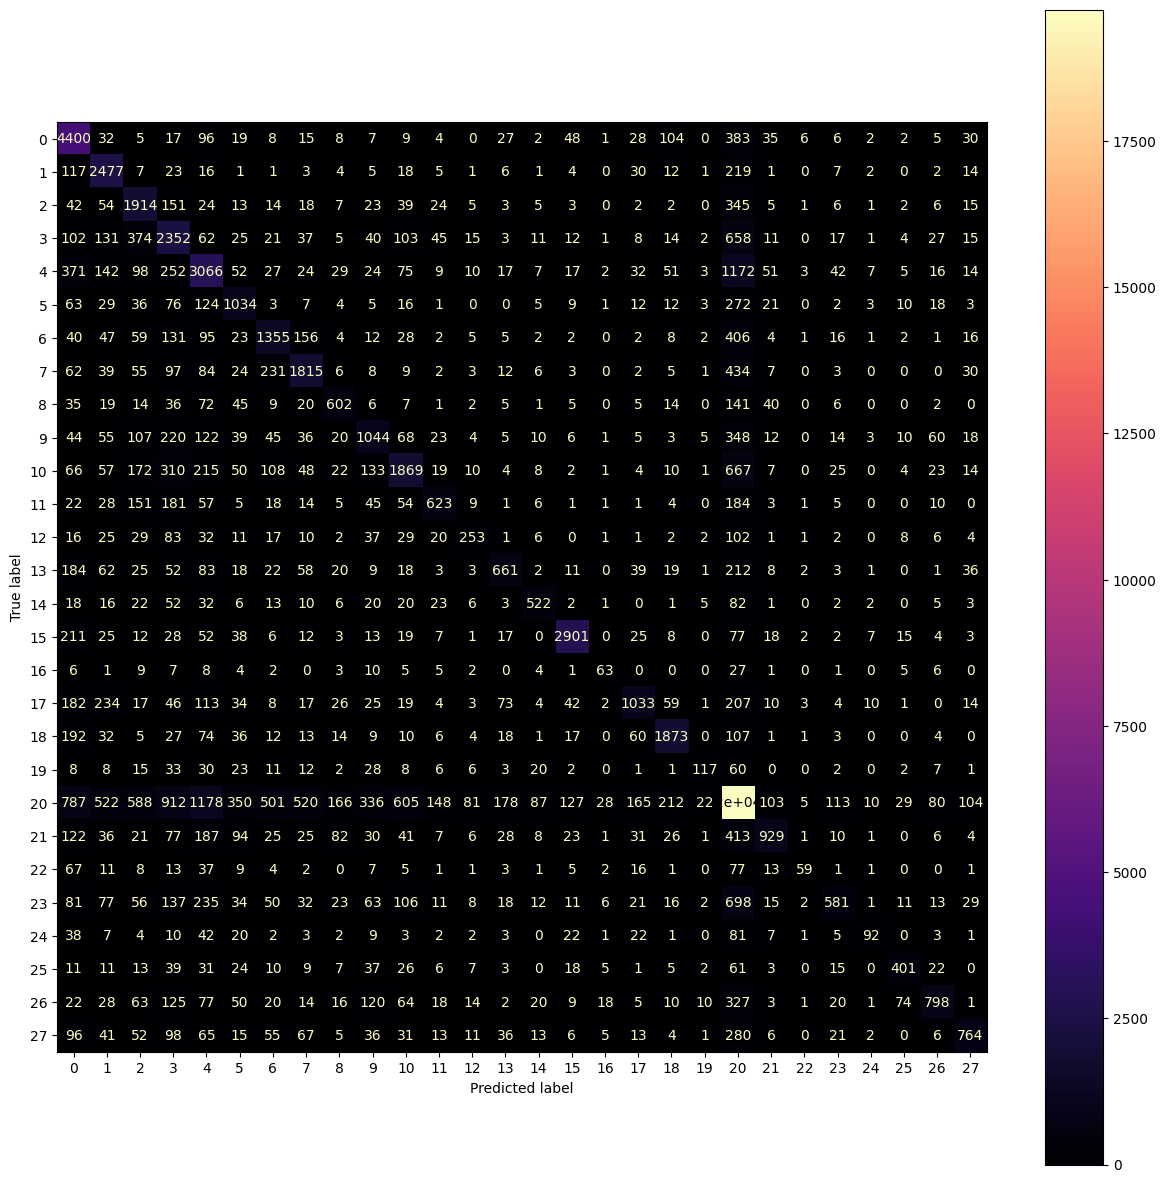

In [290]:
y_emo_predict = clf1.predict(X_test)

print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiment: 0.7389942963566523
Accuracy: 0.7389942963566523
Precision (Weighted): 0.7462788779481586
F1 Score (Weighted): 0.7407106161715152
F1 Score (Macro): 0.724553679031085
              precision    recall  f1-score   support

           0       0.60      0.71      0.65      9454
           1       0.70      0.78      0.74     19272
           2       0.73      0.70      0.71     27702
           3       0.84      0.76      0.80     29482

    accuracy                           0.74     85910
   macro avg       0.72      0.74      0.72     85910
weighted avg       0.75      0.74      0.74     85910



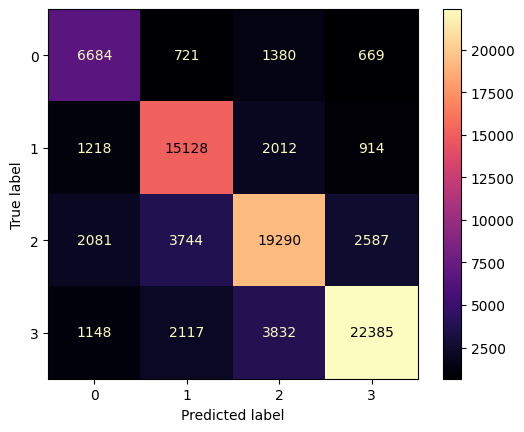

In [291]:
y_sent_predict = clf2.predict(X_test)

print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron (neural network.MLPClassifier) using new test train split</h2>

<b>Did not converge timed out</b>

In [292]:
classifier = MLPClassifier()
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP1 = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP1_model_new_split.pickle', 'rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        MLP2 = classifier.fit(X_train, ysent_train)
        with open('models/new_split/MLP2_model_new_split.pickle', 'wb') as f:
            pickle.dump(classifier, f)
        pickle_in = open('models/new_split/MLP2_model_new_split.pickle', 'rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


Score for Emotion: 0.5980328250494704
Accuracy: 0.5980328250494704
Precision (Weighted): 0.5900399651464413
F1 Score (Weighted): 0.5896334774102036
F1 Score (Macro): 0.5246161785531581
              precision    recall  f1-score   support

           0       0.64      0.72      0.68      5299
           1       0.64      0.70      0.67      2977
           2       0.59      0.46      0.52      2724
           3       0.47      0.39      0.43      4096
           4       0.54      0.37      0.44      5618
           5       0.51      0.47      0.49      1769
           6       0.56      0.40      0.47      2425
           7       0.58      0.57      0.58      2938
           8       0.48      0.57      0.52      1087
           9       0.49      0.36      0.41      2327
          10       0.52      0.47      0.49      3849
          11       0.50      0.48      0.49      1429
          12       0.41      0.49      0.45       701
          13       0.52      0.43      0.47      1553
    

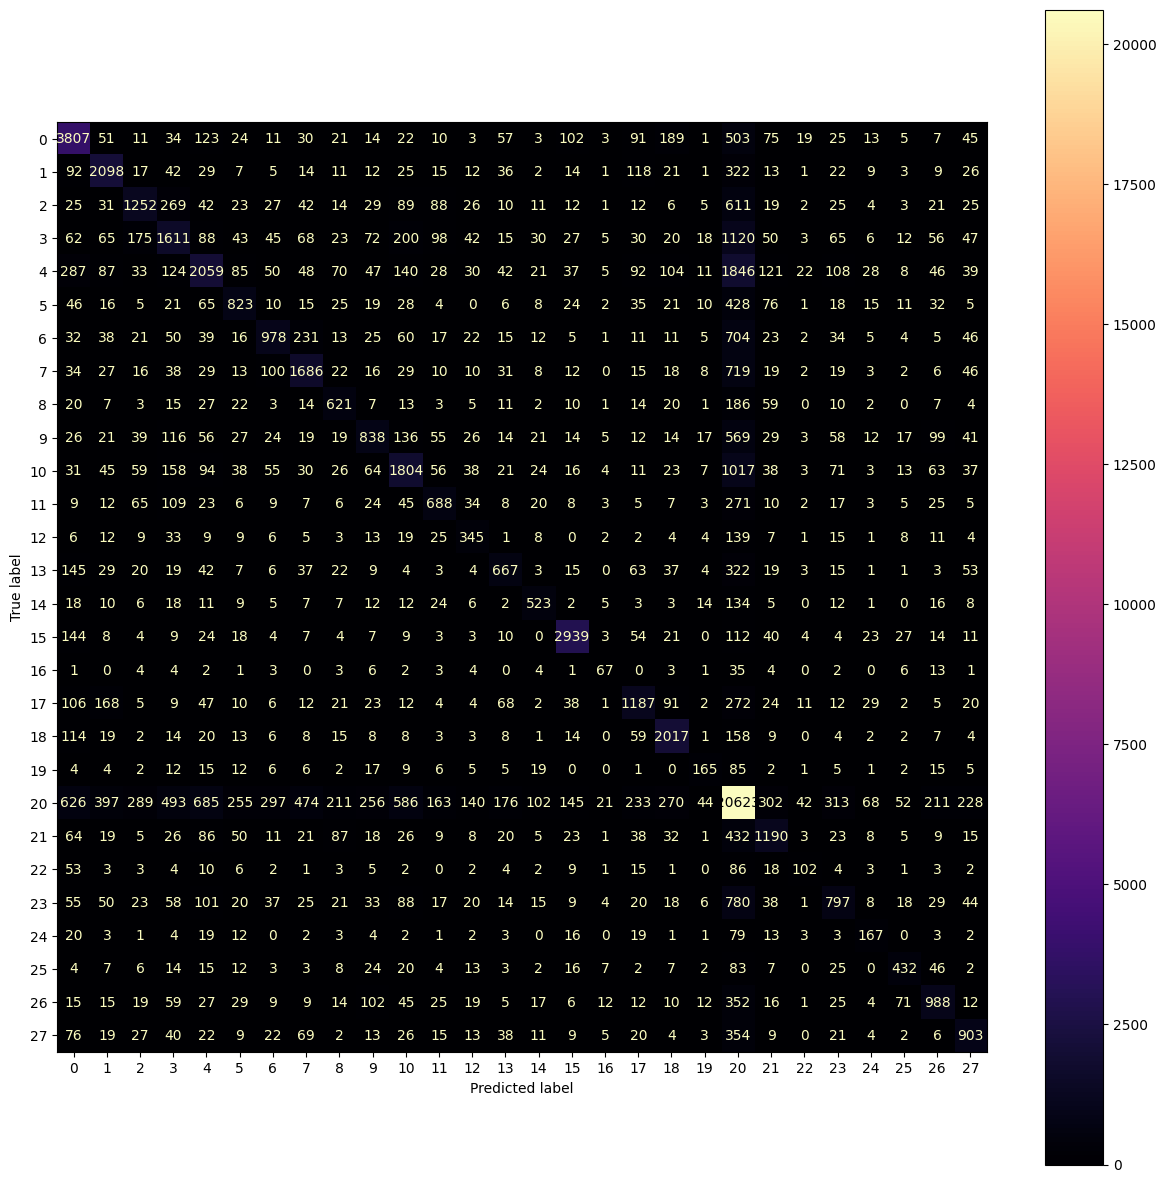

In [293]:

if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.predict(X_test)
    print(f"Score for Emotion: {clf1.score(X_test, yemo_test)}")
    metrics(yemo_test, y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
    fig, ax = plt.subplots(figsize=(15, 15))
    cmp.plot(ax=ax, cmap='magma')
else:
    print("skipped")

Score for Sentiment: 0.7249097893143988
Accuracy: 0.7249097893143988
Precision (Weighted): 0.7238345610790462
F1 Score (Weighted): 0.7241082583580896
F1 Score (Macro): 0.7037290243905212
              precision    recall  f1-score   support

           0       0.65      0.58      0.61      9454
           1       0.71      0.73      0.72     19272
           2       0.70      0.69      0.69     27702
           3       0.79      0.80      0.79     29482

    accuracy                           0.72     85910
   macro avg       0.71      0.70      0.70     85910
weighted avg       0.72      0.72      0.72     85910



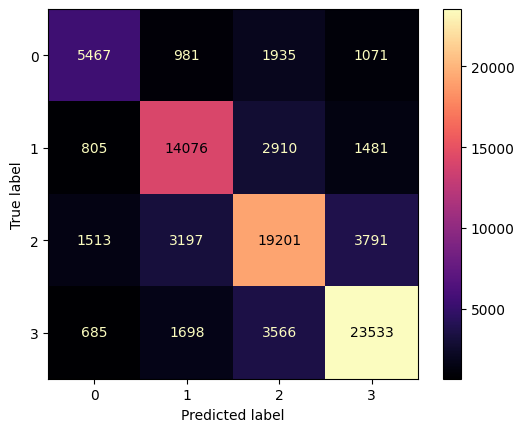

In [294]:
if (os.path.exists('models/new_split/MLP1_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.predict(X_test)

    print(f"Score for Sentiment: {clf2.score(X_test, ysent_test)}")
    metrics(ysent_test, y_sent_predict)
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h2>Multinomial Naive Bayes Classifier found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the following alpha parameters 0.5,0,0.36,1

In [295]:
parameters = {"alpha": (0.5, 0, 0.36, 1)}
clfMNB = MultinomialNB()

classifier = GridSearchCV(estimator=clfMNB, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/MNB1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/MNB1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/MNB2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/MNB2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/MNB2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): MultinomialNB(alpha=0.5), Best Score: 0.3905984755012737
Accuracy: 0.4860318938423932
Precision (Weighted): 0.4877341979896015
F1 Score (Weighted): 0.45535071771618657
F1 Score (Macro): 0.3450728098176038
              precision    recall  f1-score   support

           0       0.54      0.61      0.57      5299
           1       0.59      0.60      0.59      2977
           2       0.50      0.33      0.40      2724
           3       0.38      0.24      0.29      4096
           4       0.43      0.24      0.31      5618
           5       0.38      0.27      0.32      1769
           6       0.45      0.24      0.31      2425
           7       0.51      0.31      0.39      2938
           8       0.53      0.20      0.29      1087
           9       0.42      0.18      0.25      2327
          10       0.42      0.27      0.33      3849
          11       0.52      0.27      0.35      1429
          12       0.60      0.13      0.22       701
          13

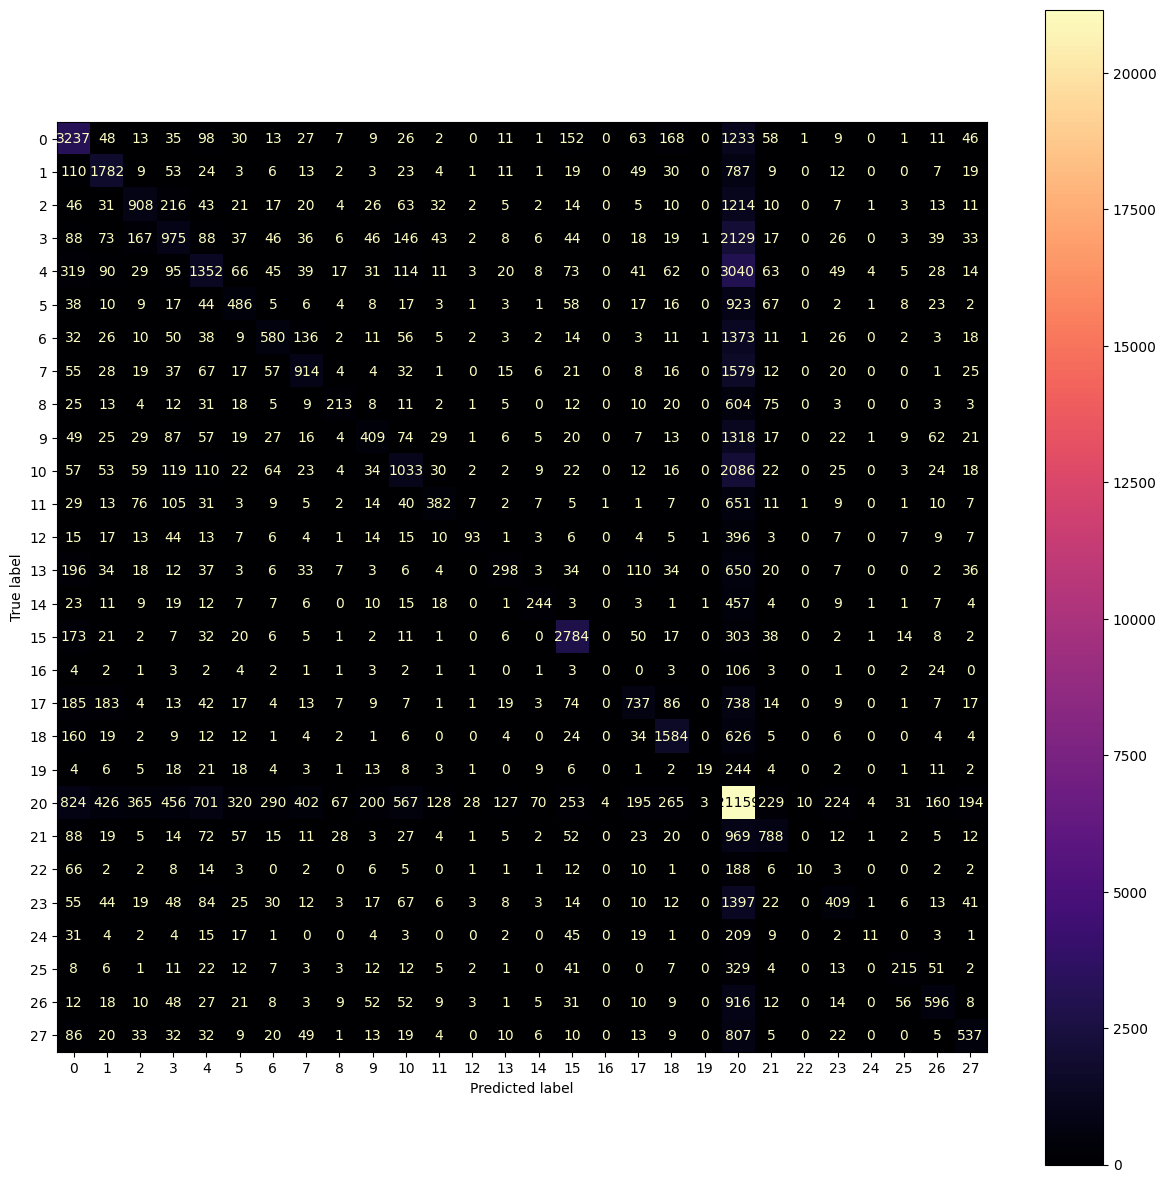

In [296]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): MultinomialNB(alpha=1), Best Score: 0.543696292227927
Accuracy: 0.6143638691654056
Precision (Weighted): 0.6090678159377672
F1 Score (Weighted): 0.6083556905625425
F1 Score (Macro): 0.5757119974496441
              precision    recall  f1-score   support

           0       0.54      0.34      0.42      9454
           1       0.61      0.61      0.61     19272
           2       0.57      0.57      0.57     27702
           3       0.67      0.75      0.71     29482

    accuracy                           0.61     85910
   macro avg       0.60      0.57      0.58     85910
weighted avg       0.61      0.61      0.61     85910



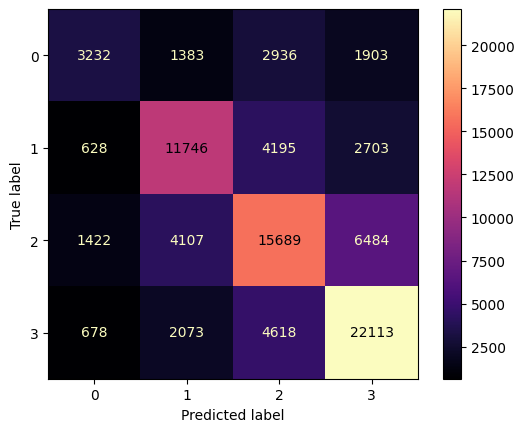

In [297]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>DecisionTree Classifier found using GridSearchCV and new test train split </h2>

input parameter requires a model object

using the various value for the following parameters: criterion, max_depth, min_samples

In [298]:
parameters = {"criterion": ("gini", "entropy"), "max_depth": (100, 3), "min_samples_split": (12, 5, 30)}
clfDT = DecisionTreeClassifier()

classifier = GridSearchCV(estimator=clfDT, param_grid=parameters, n_jobs=-1)

if (os.path.exists('models/new_split/DT1GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, yemo_train)
    with open('models/new_split/DT1GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT1GridCV_model_new_split.pickle', 'rb')
    clf1 = pickle.load(pickle_in)

if (os.path.exists('models/new_split/DT2GridCV_model_new_split.pickle')):
    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)
    print("pickle file used")
else:
    classifier = classifier.fit(X_train, ysent_train)
    with open('models/new_split/DT2GridCV_model_new_split.pickle', 'wb') as f:
        pickle.dump(classifier, f)

    pickle_in = open('models/new_split/DT2GridCV_model_new_split.pickle', 'rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


Best estimator (Emotion): DecisionTreeClassifier(max_depth=100, min_samples_split=30), Best Score: 0.3984285880572692
Accuracy: 0.4705971365382377
Precision (Weighted): 0.46097662790432326
F1 Score (Weighted): 0.4251342322120306
F1 Score (Macro): 0.3217011954018187
              precision    recall  f1-score   support

           0       0.55      0.52      0.53      5299
           1       0.56      0.58      0.57      2977
           2       0.45      0.26      0.33      2724
           3       0.29      0.16      0.21      4096
           4       0.34      0.15      0.21      5618
           5       0.35      0.14      0.20      1769
           6       0.41      0.20      0.27      2425
           7       0.46      0.22      0.30      2938
           8       0.43      0.27      0.33      1087
           9       0.33      0.13      0.19      2327
          10       0.35      0.16      0.22      3849
          11       0.44      0.21      0.29      1429
          12       0.56      0.

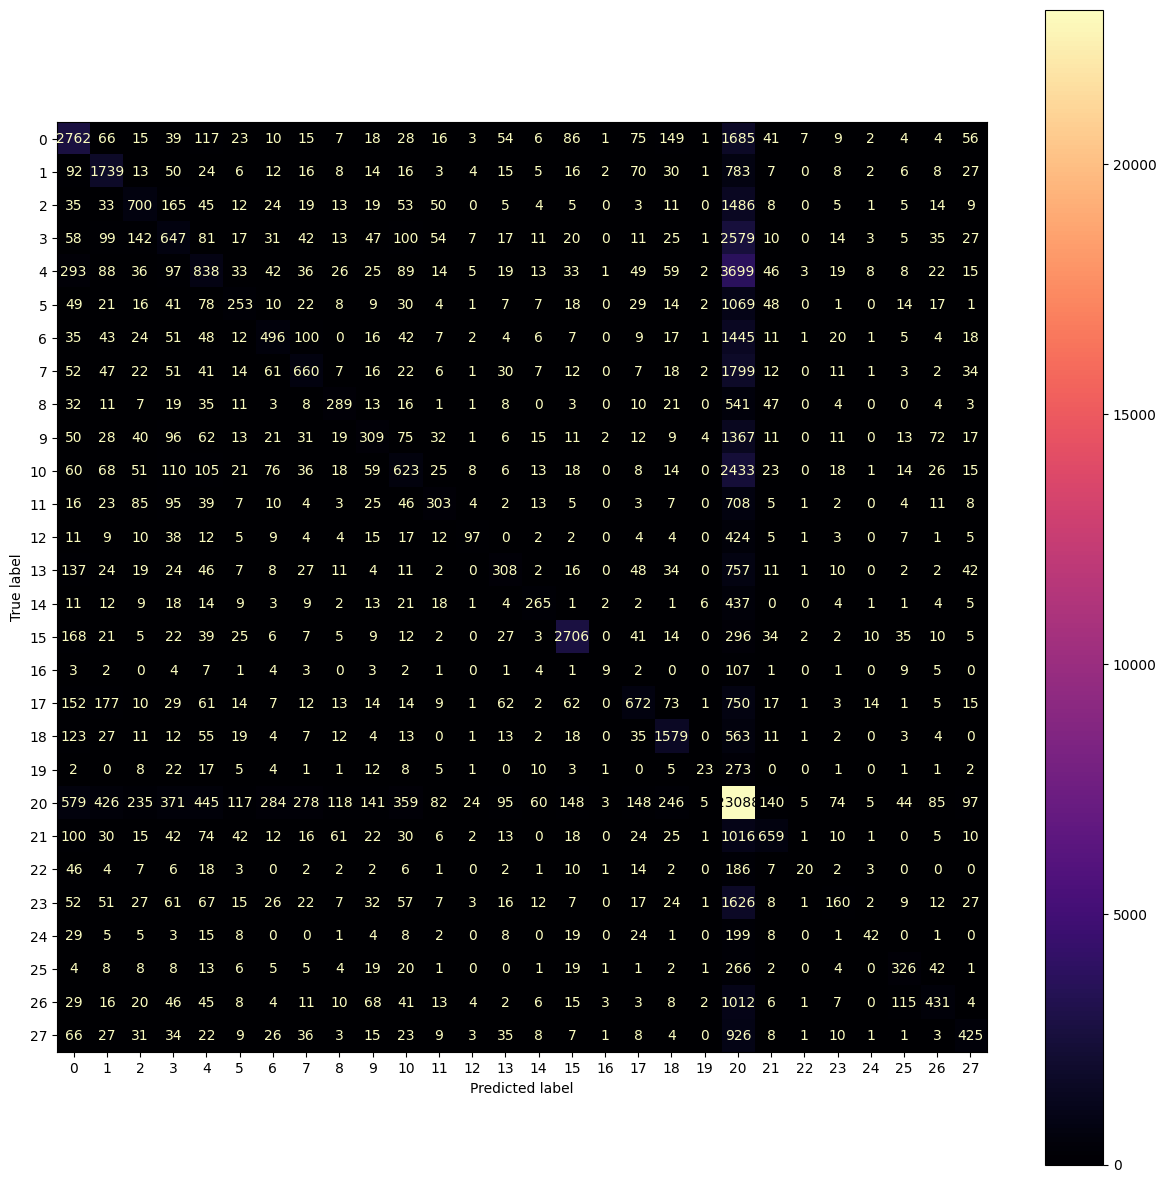

In [299]:
y_emo_predict = clf1.best_estimator_.predict(X_test)

print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
metrics(yemo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15, 15))
cmp.plot(ax=ax, cmap='magma')


Best estimator (Sentiment): DecisionTreeClassifier(max_depth=100, min_samples_split=5), Best Score: 0.49976719823070653
Accuracy: 0.5847514841112792
Precision (Weighted): 0.6295750971615053
F1 Score (Weighted): 0.5830138401647044
F1 Score (Macro): 0.5492961785749033
              precision    recall  f1-score   support

           0       0.51      0.34      0.41      9454
           1       0.65      0.45      0.53     19272
           2       0.48      0.78      0.59     27702
           3       0.80      0.57      0.66     29482

    accuracy                           0.58     85910
   macro avg       0.61      0.53      0.55     85910
weighted avg       0.63      0.58      0.58     85910



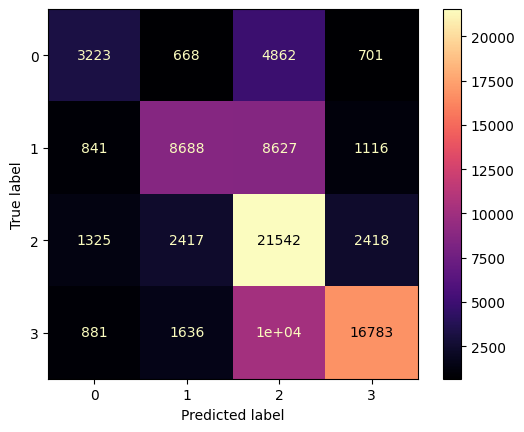

In [300]:
y_sent_predict = clf2.best_estimator_.predict(X_test)

print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
metrics(ysent_test, y_sent_predict)
ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')

<h2>Multi-Layered Perceptron found using GridSearchCV and new test train split</h2>

input parameter requires a model object

using the various value for the following parameters: activation, architectures, solvers
Hidden layers <a href="https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv">Link</a>

<b>Unable to converge</b>


In [301]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True,verbose=True, max_iter=5)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters, n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train, yemo_train)
        with open('models/new_split/MLP1GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_new_split.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_train,ysent_train)
        with open('models/new_split/MLP2GridCV_model_new_split.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_new_split.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used


Accuracy: 0.43705040158305203
Precision (Weighted): 0.3790354127296568
F1 Score (Weighted): 0.3450358914718369
F1 Score (Macro): 0.20363554898543915
              precision    recall  f1-score   support

           0       0.47      0.55      0.51      5299
           1       0.55      0.61      0.58      2977
           2       0.39      0.09      0.14      2724
           3       0.23      0.01      0.03      4096
           4       0.41      0.06      0.10      5618
           5       0.25      0.05      0.08      1769
           6       0.33      0.09      0.15      2425
           7       0.28      0.13      0.18      2938
           8       0.44      0.15      0.22      1087
           9       0.00      0.00      0.00      2327
          10       0.29      0.02      0.03      3849
          11       0.56      0.11      0.18      1429
          12       0.00      0.00      0.00       701
          13       0.35      0.02      0.03      1553
          14       0.00      0.00      0

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms


Best estimator (Emotion): MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(5, 10), max_iter=5, verbose=True), Best Score: 0.4037015481317658
Accuracy: 0.43705040158305203
Precision (Weighted): 0.3790354127296568
F1 Score (Weighted): 0.3450358914718369
F1 Score (Macro): 0.20363554898543915
              precision    recall  f1-score   support

           0       0.47      0.55      0.51      5299
           1       0.55      0.61      0.58      2977
           2       0.39      0.09      0.14      2724
           3       0.23      0.01      0.03      4096
           4       0.41      0.06      0.10      5618
           5       0.25      0.05      0.08      1769
           6       0.33      0.09      0.15      2425
           7       0.28      0.13      0.18      2938
           8       0.44      0.15      0.22      1087
           9       0.00      0.00      0.00      2327
          10       0.29      0.02      0.03      3849
          11     

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

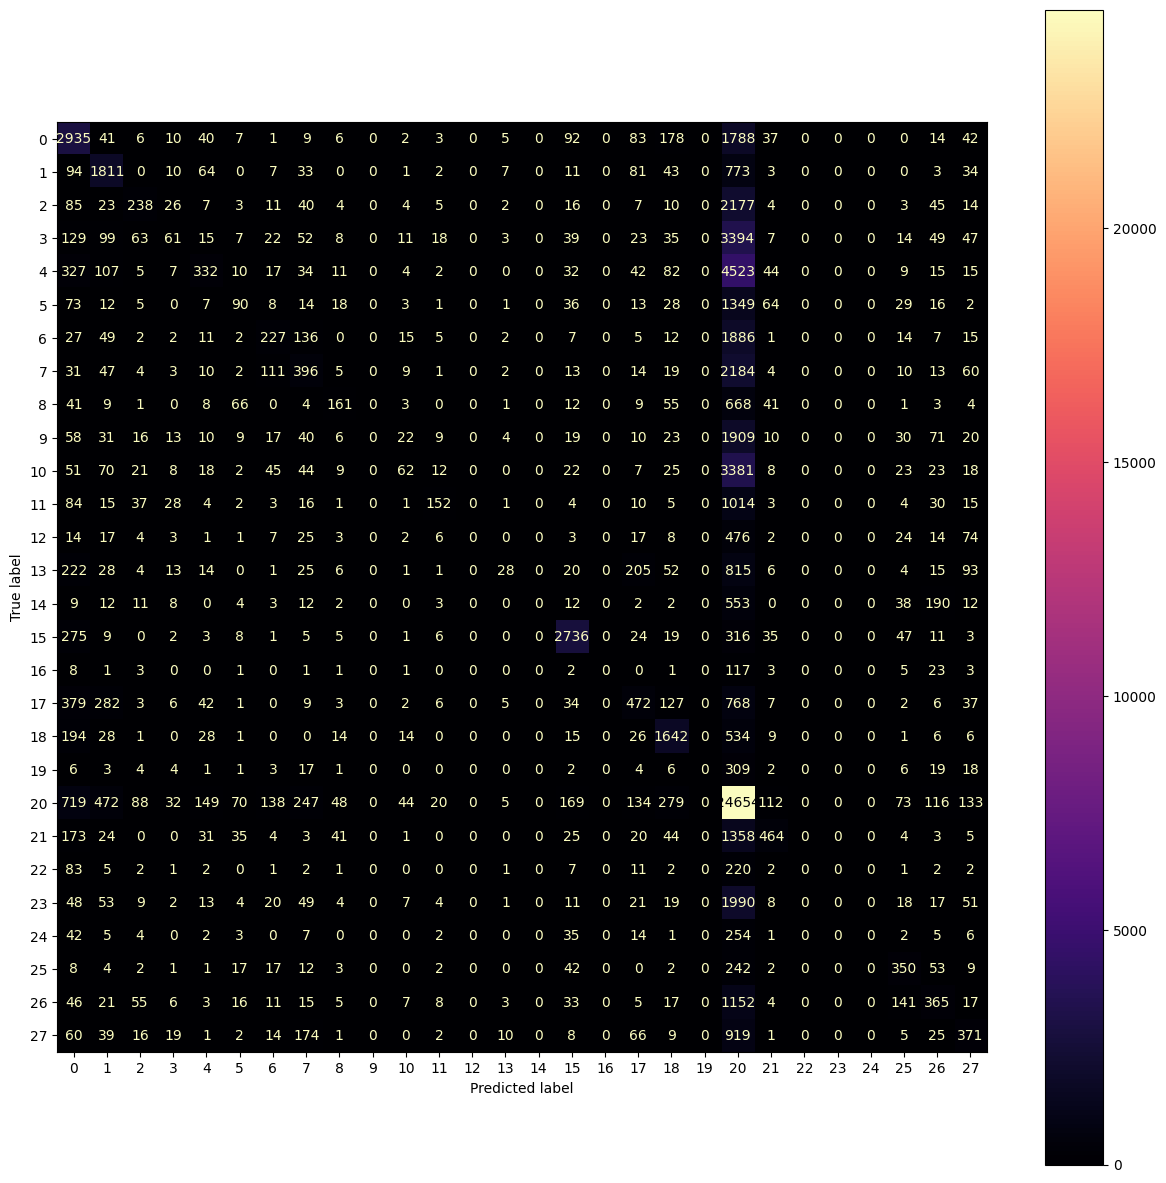

In [302]:
if (os.path.exists('models/new_split/MLP1GridCV_model_new_split.pickle') and not skip):
    y_emo_predict = clf1.best_estimator_.predict(X_test)
    metrics(yemo_test,y_emo_predict)
    print(f"Best estimator (Emotion): {clf1.best_estimator_}, Best Score: {clf1.best_score_}")
    metrics(yemo_test,y_emo_predict)
    cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=yemo_test,y_pred= y_emo_predict))
    fig, ax = plt.subplots(figsize=(15,15))
    cmp.plot(ax=ax,cmap='magma')
else:
    print("skipped")

Accuracy: 0.6045047142358282
Precision (Weighted): 0.6039311816074467
F1 Score (Weighted): 0.6008459782413754
F1 Score (Macro): 0.5633727091093732
              precision    recall  f1-score   support

           0       0.51      0.32      0.39      9454
           1       0.60      0.58      0.59     19272
           2       0.53      0.61      0.57     27702
           3       0.71      0.71      0.71     29482

    accuracy                           0.60     85910
   macro avg       0.59      0.55      0.56     85910
weighted avg       0.60      0.60      0.60     85910

Best estimator (Sentiment): MLPClassifier(activation='tanh', early_stopping=True, hidden_layer_sizes=(5, 5),
              max_iter=5, verbose=True), Best Score: 0.5505296240251426


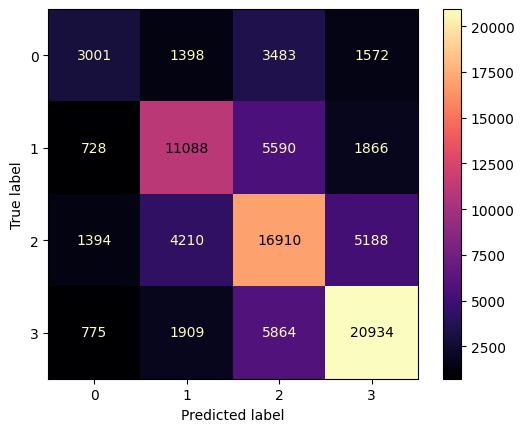

In [303]:
if (os.path.exists('models/new_split/MLP2GridCV_model_new_split.pickle') and not skip):
    y_sent_predict = clf2.best_estimator_.predict(X_test)
    metrics(ysent_test,y_sent_predict)
    print(f"Best estimator (Sentiment): {clf2.best_estimator_}, Best Score: {clf2.best_score_}")
    ConfusionMatrixDisplay.from_predictions(y_true=ysent_test, y_pred=y_sent_predict, cmap='magma')
else:
    print("skipped")

<h3>3. Embedding as features</h3>

requires install of library gensim

pip install gensim

https://radimrehurek.com/gensim/models/word2vec.html


In [304]:
# result.most_similar("cat")

In [305]:
if (os.path.exists('models/word2vec.pickle')):
    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("word2vec-google-news-300")
    with open('models/word2vec.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/word2vec.pickle','rb')
    word2vec = pickle.load(pickle_in)

pickle file used


In [306]:
nltk.download('punkt')
#post.str.lower()
tokenized_word = [word_tokenize(i) for i in post]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\james\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [307]:
post_tokens = [post_tokens for post_tokens in tokenized_word] #http://librarycarpentry.org/lc-tdm/aio/index.html
print("Number of tokens in Reddit posts:")
tokens_list = []
for i in post_tokens:
    for j in i:
        tokens_list.append(j)
print(len(tokens_list))

Number of tokens in Reddit posts:
2642128


In [308]:
X_train_emb,X_test_emb, y_emo_train, y_emo_test, y_sent_train, y_sent_test= train_test_split(post_tokens, encodedEmo, encodedSentiment, test_size = 0.2, train_size=0.8)

In [309]:
model = gensim.downloader.load("word2vec-google-news-300")

post_tokens_training = []

# Cleaning Google model
for post in X_train_emb:
    clean_post = [] 
    for word in post:
        if word in model:
            clean_post.append(word)
        else:
            continue
    post_tokens_training.append(clean_post)


# Average embed calculation
average_embeds_train = []
for post in post_tokens_training:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) 

    average_embeds_train.append(np.mean(token_embeddings,axis=0)) 



posts_tokens_in_model_test = [] 

# Cleaning Google model
for post in X_test_emb:
    clean_test = [] 
    for word in post:
        if word in model:
            clean_test.append(word)
        else:
            continue
    posts_tokens_in_model_test.append(clean_test)

    
# Average embed calculation
average_embeds_test = []
for post in posts_tokens_in_model_test:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) 
    average_embeds_test.append(np.mean(token_embeddings,axis=0)) 


X_embed_avg_train = average_embeds_train
X_embed_avg_test = average_embeds_test
print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
print(f"Shape of test set: {np.shape(X_embed_avg_test)}")

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Shape of training set: (137456,)
Shape of test set: (34364,)


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [310]:
#Cleaning training and test sets
# RUN TWICE
for i in range(2):
    print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
    print(np.shape(y_emo_test))

    # Remove empty posts
    for i in range(len(X_embed_avg_train)):
        if i >= len(X_embed_avg_train):
            break
        if X_embed_avg_train[i].shape == (300,):
            continue
        else:
            X_embed_avg_train.pop(i)
            y_emo_train = np.delete(y_emo_train, i)
            y_sent_train = np.delete(y_sent_train, i)

    # Remove empty posts
    for i in range(len(X_embed_avg_test)):
        if i >= len(X_embed_avg_test):
            break
        if X_embed_avg_test[i].shape == (300,):
            continue
        else:
            X_embed_avg_test.pop(i)
            y_emo_test = np.delete(y_emo_test, i)
            y_sent_test = np.delete(y_sent_test, i)


    print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
    print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
    print(np.shape(y_emo_test))

    # Convert into np array
    for i in range(len(X_embed_avg_train)):
        X_embed_avg_train[i] = np.array(X_embed_avg_train[i])

    for i in range(len(X_embed_avg_test)):
        X_embed_avg_test[i] = np.array(X_embed_avg_test[i])

Shape of test set: (34364,)
(34364,)
Shape of training set: (137380, 300)
Shape of test set: (34353, 300)
(34353,)
Shape of test set: (34353, 300)
(34353,)
Shape of training set: (137380, 300)
Shape of test set: (34353, 300)
(34353,)


In [311]:
# classifier = MLPClassifier()
classifier = MLPClassifier(max_iter=100)

if (os.path.exists('models/Embeddings_MLP_model.pickle')):
    pickle_in = open('models/Embeddings_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP = classifier.fit(X_embed_avg_train, y_emo_train)
    with open('models/Embeddings_MLP_model.pickle','wb') as f:
            pickle.dump(EMLP, f)
    pickle_in = open('models/Embeddings_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

        
if (os.path.exists('models/Embeddings_MLP_model2.pickle')):
    pickle_in = open('models/Embeddings_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP2 = classifier.fit(X_embed_avg_train, y_sent_train)
    with open('models/Embeddings_MLP_model2.pickle','wb') as f:
            pickle.dump(EMLP2, f)
    pickle_in = open('models/Embeddings_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [312]:
print(np.shape(X_embed_avg_train))
print(np.shape(y_emo_train))

(137380, 300)
(137380,)


Score for Emotions: 0.40567053823537974
Accuracy: 0.40567053823537974
Precision (Weighted): 0.3766016528791252
F1 Score (Weighted): 0.30963281940294446
F1 Score (Macro): 0.1714468271464402
              precision    recall  f1-score   support

           0       0.47      0.41      0.44      2038
           1       0.46      0.35      0.40      1197
           2       0.32      0.16      0.22       988
           3       0.24      0.02      0.05      1652
           4       0.37      0.03      0.05      2217
           5       0.35      0.05      0.09       697
           6       0.48      0.01      0.02       999
           7       0.37      0.08      0.14      1167
           8       0.60      0.08      0.13       453
           9       0.20      0.00      0.01       909
          10       0.31      0.05      0.09      1562
          11       0.33      0.08      0.13       555
          12       0.00      0.00      0.00       286
          13       0.49      0.03      0.06       617


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

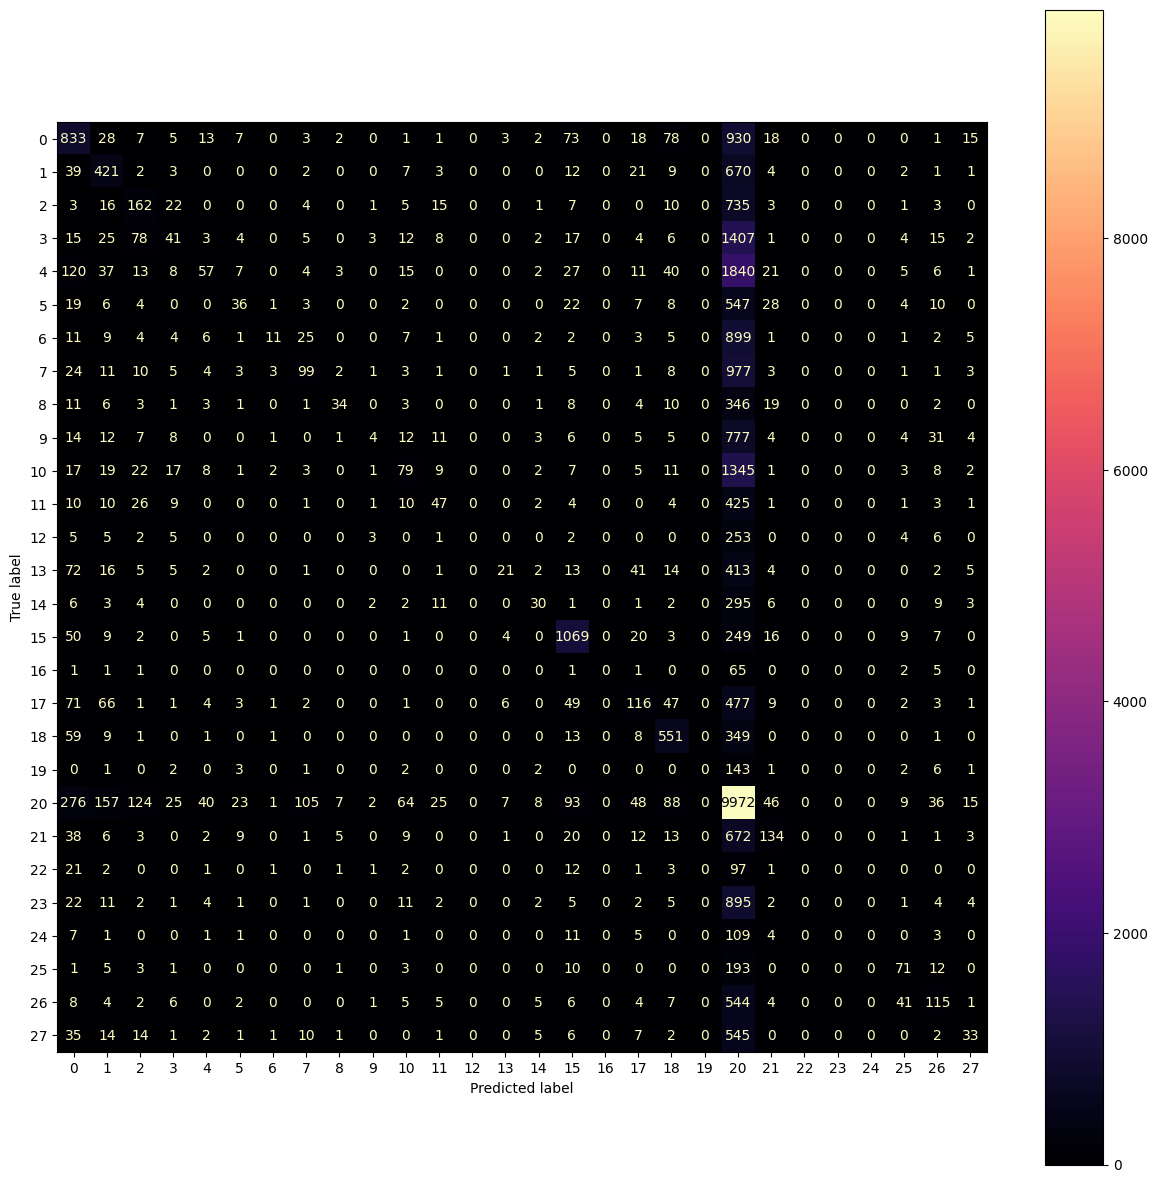

In [313]:
y_emo_predict = clf1.predict(X_embed_avg_test)
print(f"Score for Emotions: {clf1.score(X_embed_avg_test, y_emo_test)}")
metrics(y_emo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_emo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiments: 0.5357901784414753
Accuracy: 0.5357901784414753
Precision (Weighted): 0.5328862383901186
F1 Score (Weighted): 0.5195987604975748
F1 Score (Macro): 0.462108532444813
              precision    recall  f1-score   support

           0       0.47      0.13      0.20      3821
           1       0.53      0.44      0.48      7628
           2       0.47      0.59      0.52     11171
           3       0.62      0.68      0.65     11733

    accuracy                           0.54     34353
   macro avg       0.52      0.46      0.46     34353
weighted avg       0.53      0.54      0.52     34353



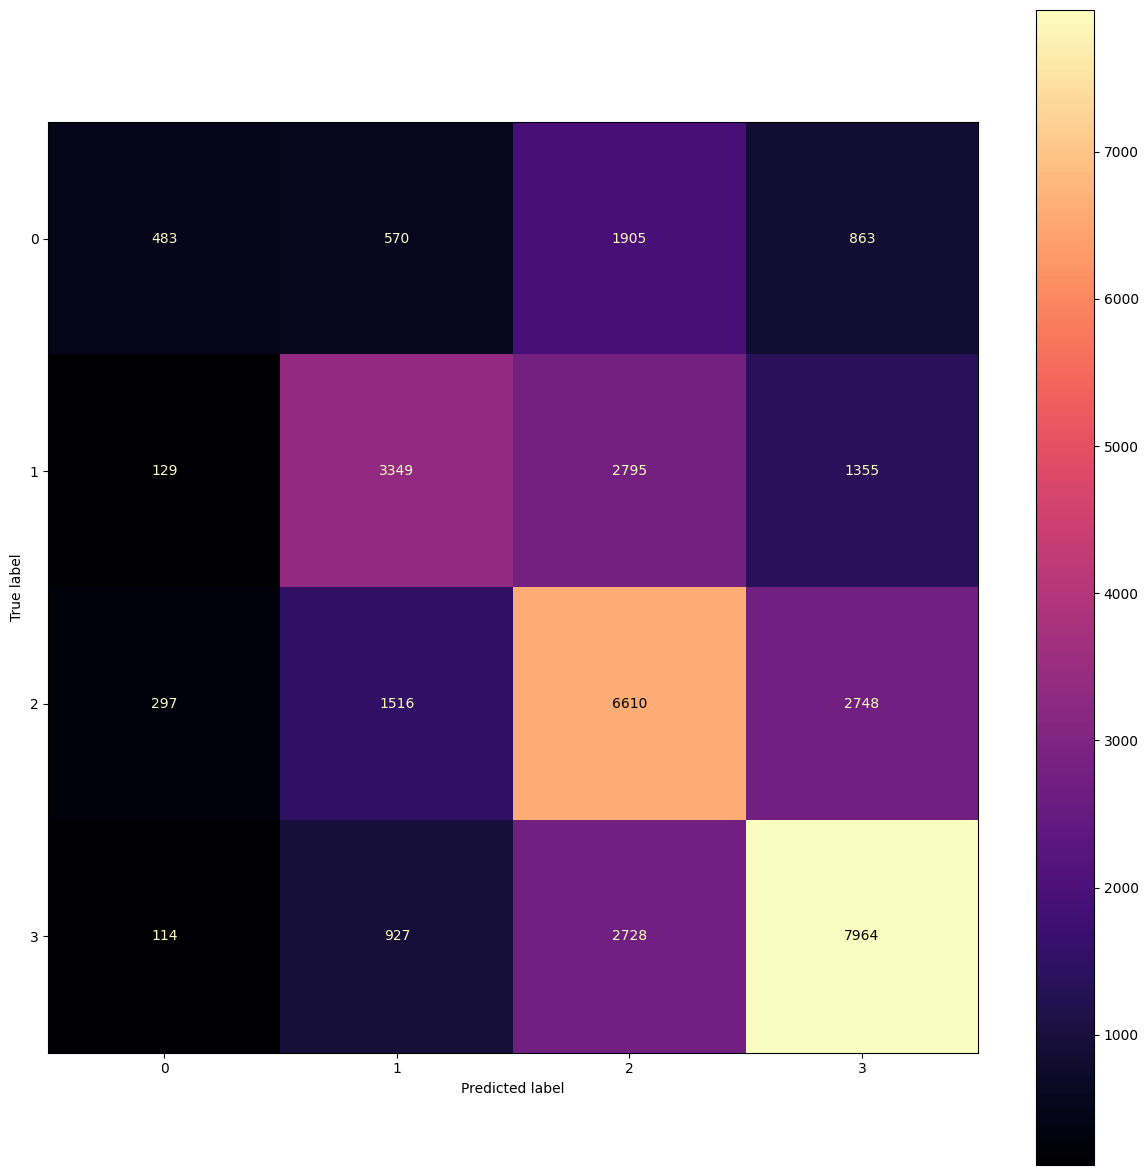

In [314]:
y_sent_predict = clf2.predict(X_embed_avg_test)
print(f"Score for Sentiments: {clf2.score(X_embed_avg_test, y_sent_test)}")
metrics(y_sent_test, y_sent_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_sent_test, y_pred=y_sent_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

In [315]:
print(np.shape(X_embed_avg_train))

(137380, 300)


In [316]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True,verbose=True, max_iter=100)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters, n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        X_embed_avg_train, y_emo_train
        classifier = classifier.fit(X_embed_avg_train, y_emo_train)
        with open('models/new_split/MLP1GridCV_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_embed_avg_train,y_sent_train)
        with open('models/new_split/MLP2GridCV_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

Iteration 1, loss = 2.78368546
Validation score: 0.328578
Iteration 2, loss = 2.57340542
Validation score: 0.360824
Iteration 3, loss = 2.45083682
Validation score: 0.368176
Iteration 4, loss = 2.38989698
Validation score: 0.371160
Iteration 5, loss = 2.34811454
Validation score: 0.374509
Iteration 6, loss = 2.32075470
Validation score: 0.378439
Iteration 7, loss = 2.30214295
Validation score: 0.380259
Iteration 8, loss = 2.28939066
Validation score: 0.381424
Iteration 9, loss = 2.28005362
Validation score: 0.381715
Iteration 10, loss = 2.27321479
Validation score: 0.382952
Iteration 11, loss = 2.26773753
Validation score: 0.383535
Iteration 12, loss = 2.26345925
Validation score: 0.384408
Iteration 13, loss = 2.26012274
Validation score: 0.385282
Iteration 14, loss = 2.25755254
Validation score: 0.385646
Iteration 15, loss = 2.25552320
Validation score: 0.385209
Iteration 16, loss = 2.25345696
Validation score: 0.385354
Iteration 17, loss = 2.25241266
Validation score: 0.386301
Iterat

In [317]:
if (os.path.exists('models/twitter.pickle')):
    pickle_in = open('models/twitter.pickle','rb')
    twitter = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("glove-twitter-100")
    with open('models/twitter.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/twitter.pickle','rb')
    twitter = pickle.load(pickle_in)

pickle file used


In [318]:
model = gensim.downloader.load("glove-twitter-100")
X_train_emb,X_test_emb, y_emo_train, y_emo_test, y_sent_train, y_sent_test= train_test_split(post_tokens, encodedEmo, encodedSentiment, test_size = 0.2, train_size=0.8)
post_tokens_training = [] 

# Cleaning Twitter model
for post in X_train_emb:
    clean_post = [] 
    for word in post:
        if word in model:
            clean_post.append(word)
        else:
            continue
    post_tokens_training.append(clean_post)


# Average embed calculation
average_embeds_train = []
for post in post_tokens_training:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) 
   
    average_embeds_train.append(np.mean(token_embeddings,axis=0)) 


posts_tokens_in_model_test = [] 

# Cleaning Twitter model
for post in X_test_emb:
    clean_test = [] 
    for word in post:
        if word in model:
            clean_test.append(word)
        else:
            continue
    posts_tokens_in_model_test.append(clean_test)

    
# Average embed calculation
average_embeds_test = []
for post in posts_tokens_in_model_test:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) 
    average_embeds_test.append(np.mean(token_embeddings,axis=0))


X_embed_avg_train = average_embeds_train
X_embed_avg_test = average_embeds_test
print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
print(f"Shape of test set: {np.shape(X_embed_avg_test)}")

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Shape of training set: (137456,)
Shape of test set: (34364,)


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [319]:
# Cleaning training and test sets
# RUN TWICE
for i in range(2):
    print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
    print(np.shape(y_emo_test))

    # Remove empty posts
    for i in range(len(X_embed_avg_train)):
        if i >= len(X_embed_avg_train):
            break
        if X_embed_avg_train[i].shape == (100,):
            continue
        else:
            X_embed_avg_train.pop(i)
            y_emo_train = np.delete(y_emo_train, i)
            y_sent_train = np.delete(y_sent_train, i)

    # Remove empty posts
    for i in range(len(X_embed_avg_test)):
        if i >= len(X_embed_avg_test):
            break
        if X_embed_avg_test[i].shape == (100,):
            continue
        else:
            X_embed_avg_test.pop(i)
            y_emo_test = np.delete(y_emo_test, i)
            y_sent_test = np.delete(y_sent_test, i)


    print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
    print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
    print(np.shape(y_emo_test))

    # Convert to np array
    for i in range(len(X_embed_avg_train)):
        X_embed_avg_train[i] = np.array(X_embed_avg_train[i])

    for i in range(len(X_embed_avg_test)):
        X_embed_avg_test[i] = np.array(X_embed_avg_test[i])

Shape of test set: (34364,)
(34364,)
Shape of training set: (136743,)
Shape of test set: (34193,)
(34193,)
Shape of test set: (34193,)
(34193,)
Shape of training set: (136738, 100)
Shape of test set: (34191, 100)
(34191,)


In [320]:
classifier = MLPClassifier(max_iter=100)

if (os.path.exists('models/Embeddings_Twitter_MLP_model.pickle')):
    pickle_in = open('models/Embeddings_Twitter_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP = classifier.fit(X_embed_avg_train, y_emo_train)
    with open('models/Embeddings_Twitter_MLP_model.pickle','wb') as f:
            pickle.dump(EMLP, f)
    pickle_in = open('models/Embeddings_Twitter_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

        
if (os.path.exists('models/Embeddings_Twitter_MLP_model2.pickle')):
    pickle_in = open('models/Embeddings_Twitter_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP2 = classifier.fit(X_embed_avg_train, y_sent_train)
    with open('models/Embeddings_Twitter_MLP_model2.pickle','wb') as f:
            pickle.dump(EMLP2, f)
    pickle_in = open('models/Embeddings_Twitter_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)


pickle file used
pickle file used


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Score for Emotions: 0.3679915767307186
Accuracy: 0.3679915767307186
Precision (Weighted): 0.3628356344259193
F1 Score (Weighted): 0.2611198192704462
F1 Score (Macro): 0.1216496884249517
              precision    recall  f1-score   support

           0       0.45      0.33      0.38      2052
           1       0.48      0.14      0.22      1173
           2       0.36      0.07      0.12      1084
           3       0.23      0.03      0.05      1724
           4       0.57      0.01      0.03      2254
           5       0.25      0.02      0.03       722
           6       0.36      0.01      0.02       995
           7       0.35      0.19      0.25      1189
           8       0.48      0.04      0.08       445
           9       0.22      0.00      0.00       923
          10       0.26      0.02      0.03      1509
          11       0.33      0.06      0.10       562
          12       0.00      0.00      0.00       273
          13       0.36      0.04      0.07       566
   

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

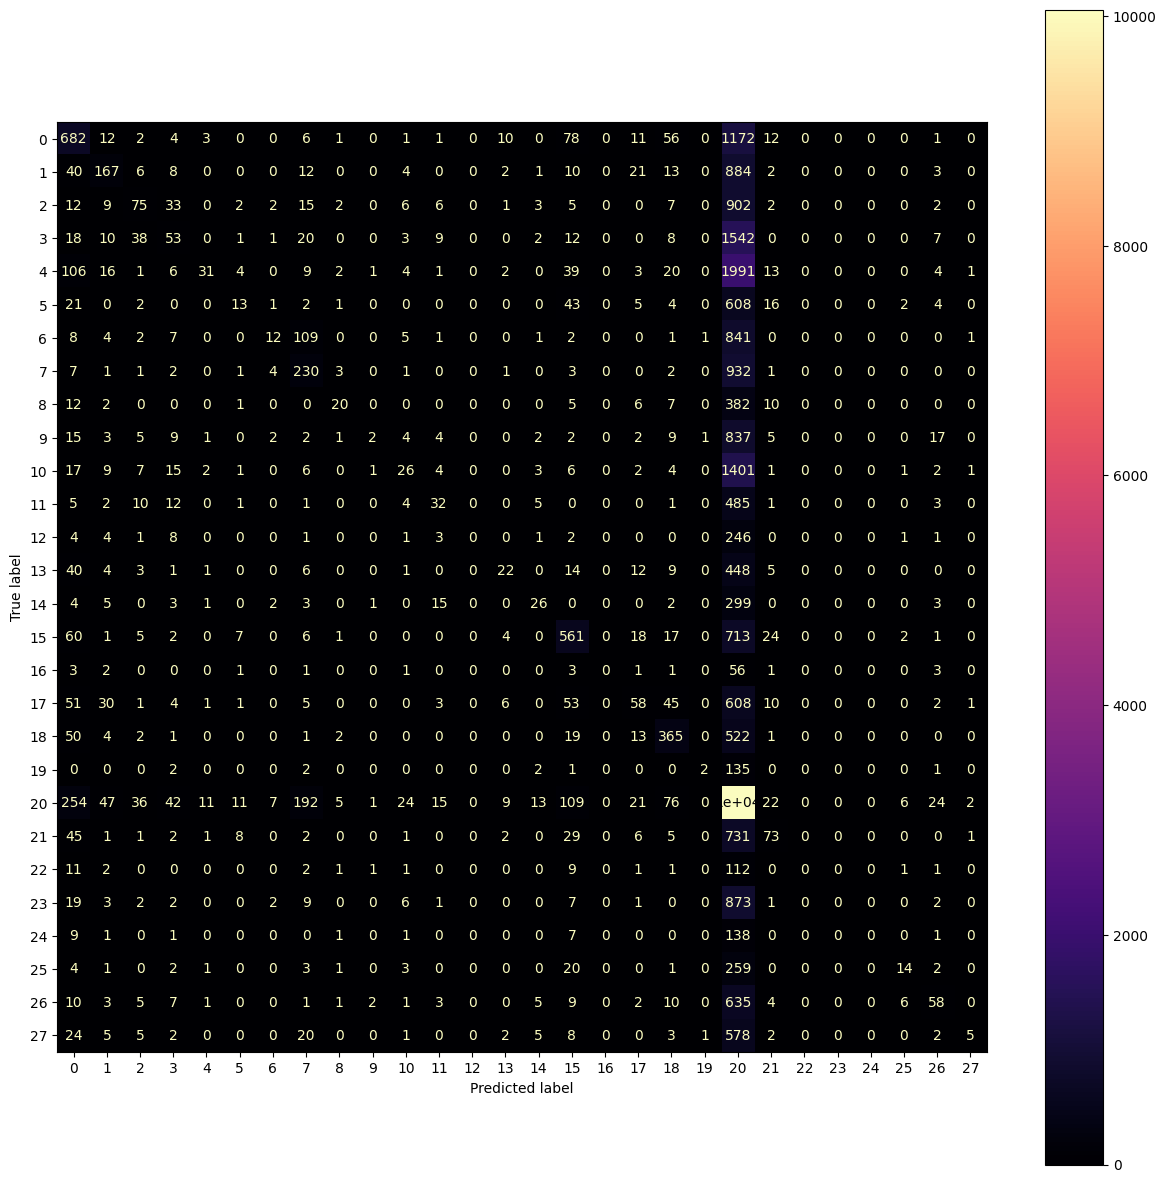

In [321]:
y_emo_predict = clf1.predict(X_embed_avg_test)
print(f"Score for Emotions: {clf1.score(X_embed_avg_test, y_emo_test)}")
metrics(y_emo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_emo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiments: 0.49700213506478313
Accuracy: 0.49700213506478313
Precision (Weighted): 0.5078246201807983
F1 Score (Weighted): 0.4878377367196978
F1 Score (Macro): 0.44234578092707083
              precision    recall  f1-score   support

           0       0.52      0.15      0.24      3775
           1       0.47      0.44      0.45      7731
           2       0.43      0.57      0.49     10982
           3       0.61      0.58      0.59     11703

    accuracy                           0.50     34191
   macro avg       0.50      0.43      0.44     34191
weighted avg       0.51      0.50      0.49     34191



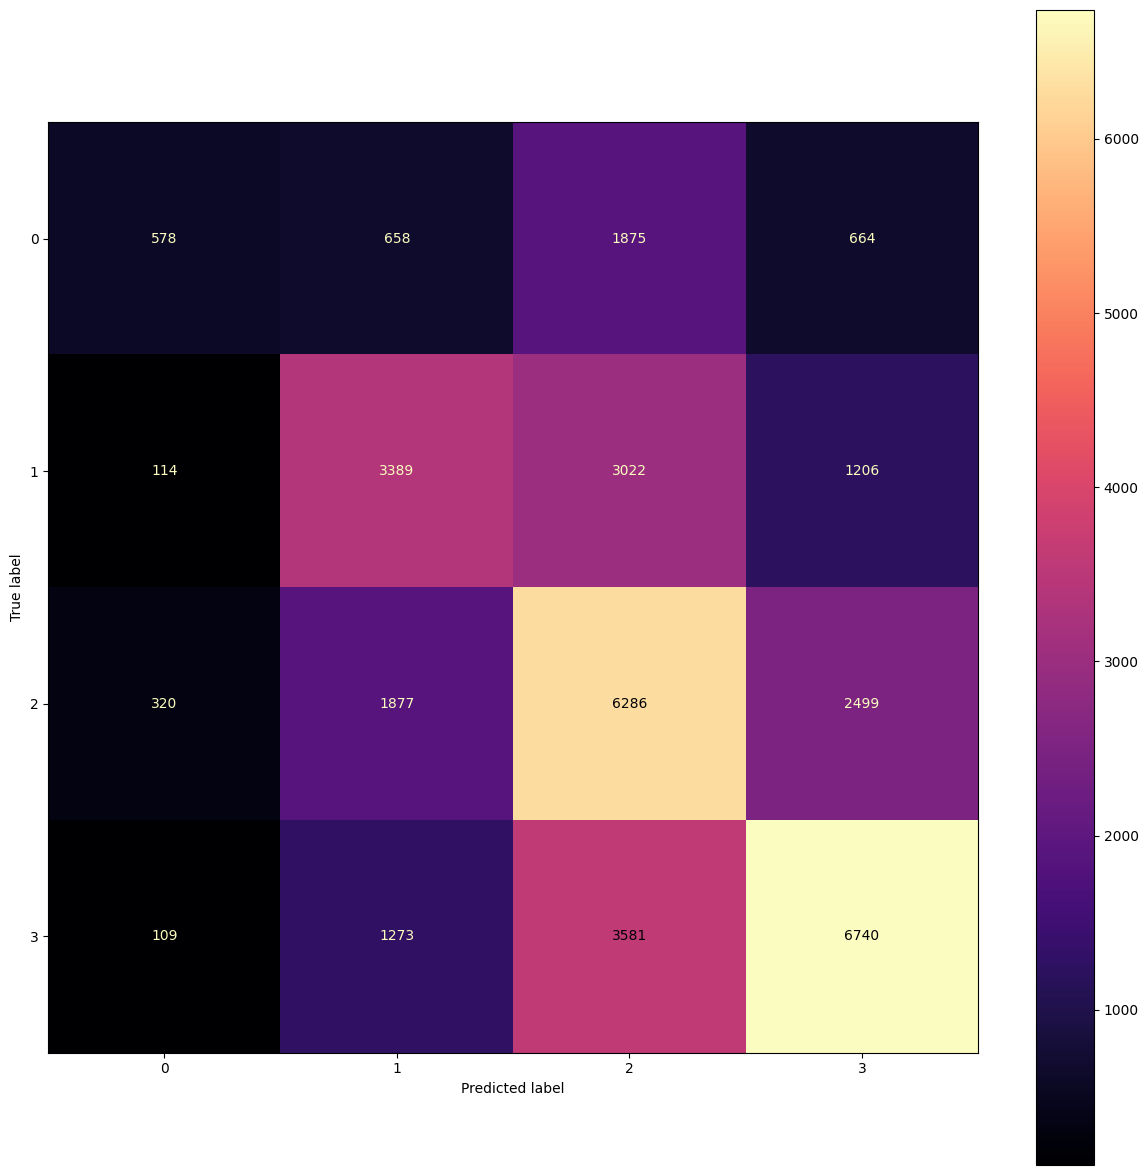

In [322]:
y_sent_predict = clf2.predict(X_embed_avg_test)
print(f"Score for Sentiments: {clf2.score(X_embed_avg_test, y_sent_test)}")
metrics(y_sent_test, y_sent_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_sent_test, y_pred=y_sent_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

In [323]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True,verbose=True, max_iter=100)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters, n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_Twitter_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_Twitter_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        X_embed_avg_train, y_emo_train
        classifier = classifier.fit(X_embed_avg_train, y_emo_train)
        with open('models/new_split/MLP1GridCV_Twitter_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_Twitter_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_Twitter_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_Twitter_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_embed_avg_train,y_sent_train)
        with open('models/new_split/MLP2GridCV_Twitter_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_Twitter_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

Iteration 1, loss = 2.80922760
Validation score: 0.321559
Iteration 2, loss = 2.70823678
Validation score: 0.321705
Iteration 3, loss = 2.65329609
Validation score: 0.329311
Iteration 4, loss = 2.57840938
Validation score: 0.333260
Iteration 5, loss = 2.54195215
Validation score: 0.337721
Iteration 6, loss = 2.51050821
Validation score: 0.340646
Iteration 7, loss = 2.48632051
Validation score: 0.342182
Iteration 8, loss = 2.47414614
Validation score: 0.342182
Iteration 9, loss = 2.46692884
Validation score: 0.342767
Iteration 10, loss = 2.46216982
Validation score: 0.341378
Iteration 11, loss = 2.45851985
Validation score: 0.342255
Iteration 12, loss = 2.45539012
Validation score: 0.343499
Iteration 13, loss = 2.45291812
Validation score: 0.343572
Iteration 14, loss = 2.45052388
Validation score: 0.345034
Iteration 15, loss = 2.44850080
Validation score: 0.345839
Iteration 16, loss = 2.44674684
Validation score: 0.344157
Iteration 17, loss = 2.44499778
Validation score: 0.345034
Iterat

In [324]:
if (os.path.exists('models/wiki.pickle')):
    pickle_in = open('models/wiki.pickle','rb')
    wiki = pickle.load(pickle_in)
    print("pickle file used")
else:
    model =gensim.downloader.load("glove-wiki-gigaword-300")
    with open('models/wiki.pickle','wb') as f:
        pickle.dump(model, f)

    pickle_in = open('models/wiki.pickle','rb')
    wiki = pickle.load(pickle_in)

pickle file used


In [325]:
model = gensim.downloader.load("glove-wiki-gigaword-300")
X_train_emb,X_test_emb, y_emo_train, y_emo_test, y_sent_train, y_sent_test= train_test_split(post_tokens, encodedEmo, encodedSentiment, test_size = 0.2, train_size=0.8)
post_tokens_training = [] 

# Cleaning Wiki model
for post in X_train_emb:
    clean_post = [] 
    for word in post:
        if word in model:
            clean_post.append(word)
        else:
            continue
    post_tokens_training.append(clean_post)

    
# Average embed calculation
average_embeds_train = []
for post in post_tokens_training:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word]) 
   
    average_embeds_train.append(np.mean(token_embeddings,axis=0)) 


posts_tokens_in_model_test = [] 
# Cleaning Wiki model
for post in X_test_emb:
    clean_test = [] 
    for word in post:
        if word in model:
            clean_test.append(word)
        else:
            continue
    posts_tokens_in_model_test.append(clean_test)

    
# Average embed calculation
average_embeds_test = []
for post in posts_tokens_in_model_test:
    token_embeddings = []
    for word in post:
        token_embeddings.append(model[word])
    average_embeds_test.append(np.mean(token_embeddings,axis=0)) 


X_embed_avg_train = average_embeds_train
X_embed_avg_test = average_embeds_test
print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
print(f"Shape of test set: {np.shape(X_embed_avg_test)}")

C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Shape of training set: (137456,)
Shape of test set: (34364,)


C:\Users\james\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [326]:
#clean training and test sets
# RUN TWICE
for i in range(2):
    print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
    print(np.shape(y_emo_test))

    # Remove empty posts
    for i in range(len(X_embed_avg_train)):
        if i >= len(X_embed_avg_train):
            break
        if X_embed_avg_train[i].shape == (300,):
            continue
        else:
            X_embed_avg_train.pop(i)
            y_emo_train = np.delete(y_emo_train, i)
            y_sent_train = np.delete(y_sent_train, i)

    # Remove empty posts
    for i in range(len(X_embed_avg_test)):
        if i >= len(X_embed_avg_test):
            break
        if X_embed_avg_test[i].shape == (300,):
            continue
        else:
            X_embed_avg_test.pop(i)
            y_emo_test = np.delete(y_emo_test, i)
            y_sent_test = np.delete(y_sent_test, i)


    print(f"Shape of training set: {np.shape(X_embed_avg_train)}")
    print(f"Shape of test set: {np.shape(X_embed_avg_test)}")
    print(np.shape(y_emo_test))

    # Convert to np array
    for i in range(len(X_embed_avg_train)):
        X_embed_avg_train[i] = np.array(X_embed_avg_train[i])

    for i in range(len(X_embed_avg_test)):
        X_embed_avg_test[i] = np.array(X_embed_avg_test[i])

Shape of test set: (34364,)
(34364,)
Shape of training set: (136789,)
Shape of test set: (34182,)
(34182,)
Shape of test set: (34182,)
(34182,)
Shape of training set: (136785, 300)
Shape of test set: (34180, 300)
(34180,)


In [327]:
classifier = MLPClassifier(max_iter=100)

if (os.path.exists('models/Embeddings_Wiki_MLP_model.pickle')):
    pickle_in = open('models/Embeddings_Wiki_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP = classifier.fit(X_embed_avg_train, y_emo_train)
    with open('models/Embeddings_Wiki_MLP_model.pickle','wb') as f:
            pickle.dump(EMLP, f)
    pickle_in = open('models/Embeddings_Wiki_MLP_model.pickle','rb')
    clf1 = pickle.load(pickle_in)

        
if (os.path.exists('models/Embeddings_Wiki_MLP_model2.pickle')):
    pickle_in = open('models/Embeddings_Wiki_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)
    print('pickle file used')
else:
    EMLP2 = classifier.fit(X_embed_avg_train, y_sent_train)
    with open('models/Embeddings_Wiki_MLP_model2.pickle','wb') as f:
            pickle.dump(EMLP2, f)
    pickle_in = open('models/Embeddings_Wiki_MLP_model2.pickle','rb')
    clf2 = pickle.load(pickle_in)

pickle file used
pickle file used


Score for Emotions: 0.4219133996489175
Accuracy: 0.4219133996489175
Precision (Weighted): 0.4180194062051852
F1 Score (Weighted): 0.3461301644672839
F1 Score (Macro): 0.2360072673725874
              precision    recall  f1-score   support

           0       0.48      0.51      0.50      2105
           1       0.50      0.39      0.44      1247
           2       0.40      0.22      0.28       990
           3       0.30      0.05      0.08      1621
           4       0.39      0.04      0.07      2250
           5       0.38      0.09      0.14       697
           6       0.35      0.05      0.09       924
           7       0.42      0.29      0.34      1146
           8       0.52      0.15      0.24       427
           9       0.23      0.05      0.08       950
          10       0.33      0.07      0.11      1502
          11       0.31      0.24      0.27       590
          12       0.45      0.12      0.19       308
          13       0.60      0.09      0.15       564
   

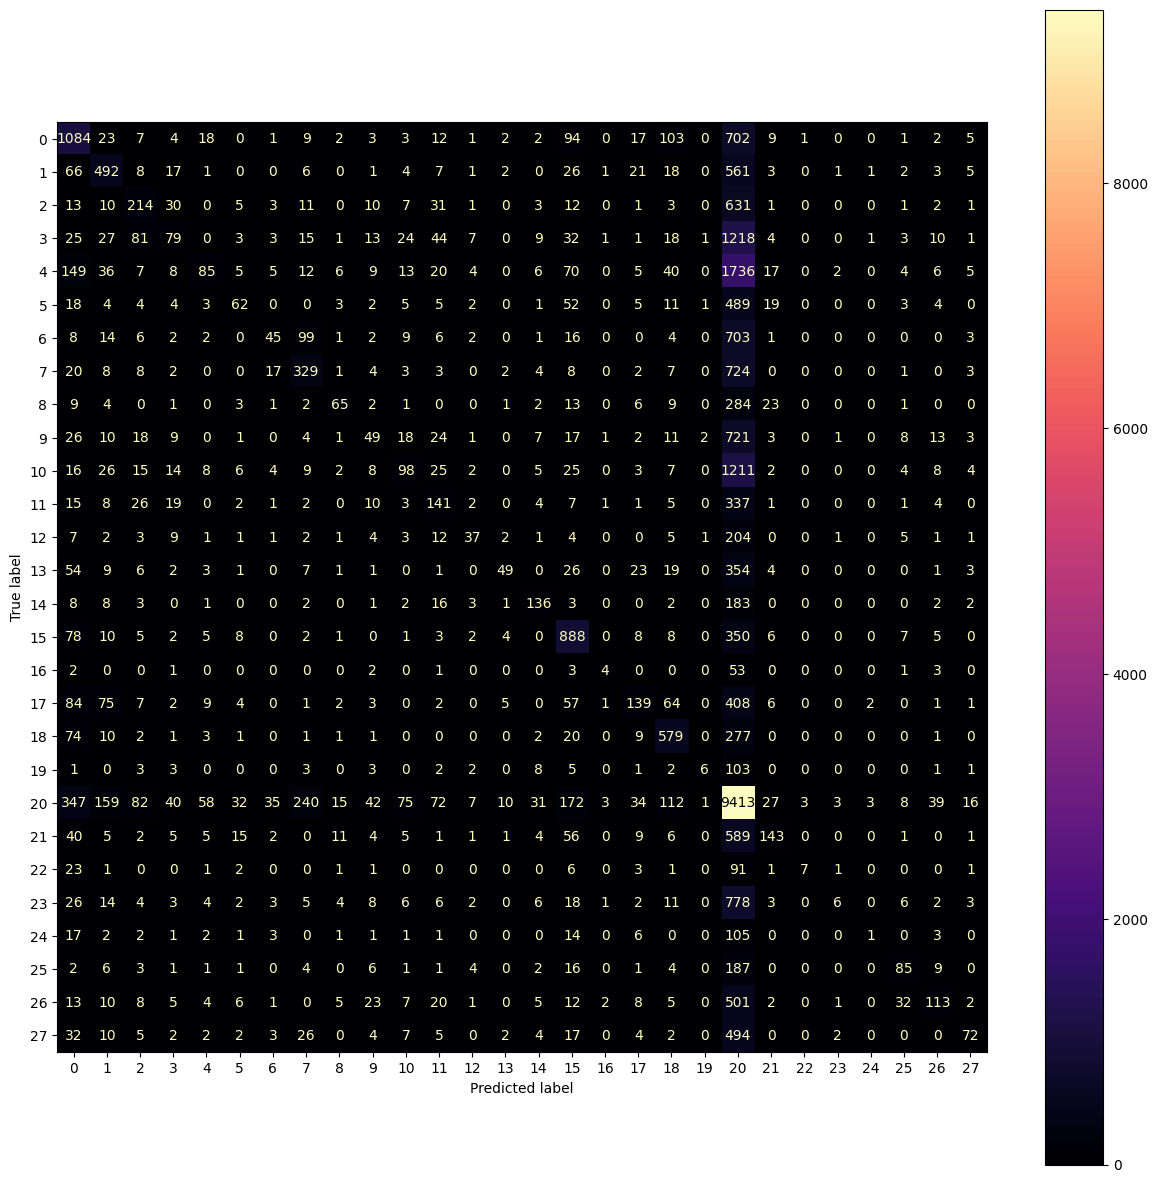

In [328]:
y_emo_predict = clf1.predict(X_embed_avg_test)
print(f"Score for Emotions: {clf1.score(X_embed_avg_test, y_emo_test)}")
metrics(y_emo_test, y_emo_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_emo_test, y_pred=y_emo_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

Score for Sentiments: 0.5780280866003511
Accuracy: 0.5780280866003511
Precision (Weighted): 0.5856603000372135
F1 Score (Weighted): 0.5771937284233294
F1 Score (Macro): 0.5485188357308813
              precision    recall  f1-score   support

           0       0.51      0.35      0.42      3688
           1       0.50      0.66      0.57      7668
           2       0.54      0.53      0.53     11079
           3       0.71      0.64      0.67     11745

    accuracy                           0.58     34180
   macro avg       0.56      0.55      0.55     34180
weighted avg       0.59      0.58      0.58     34180



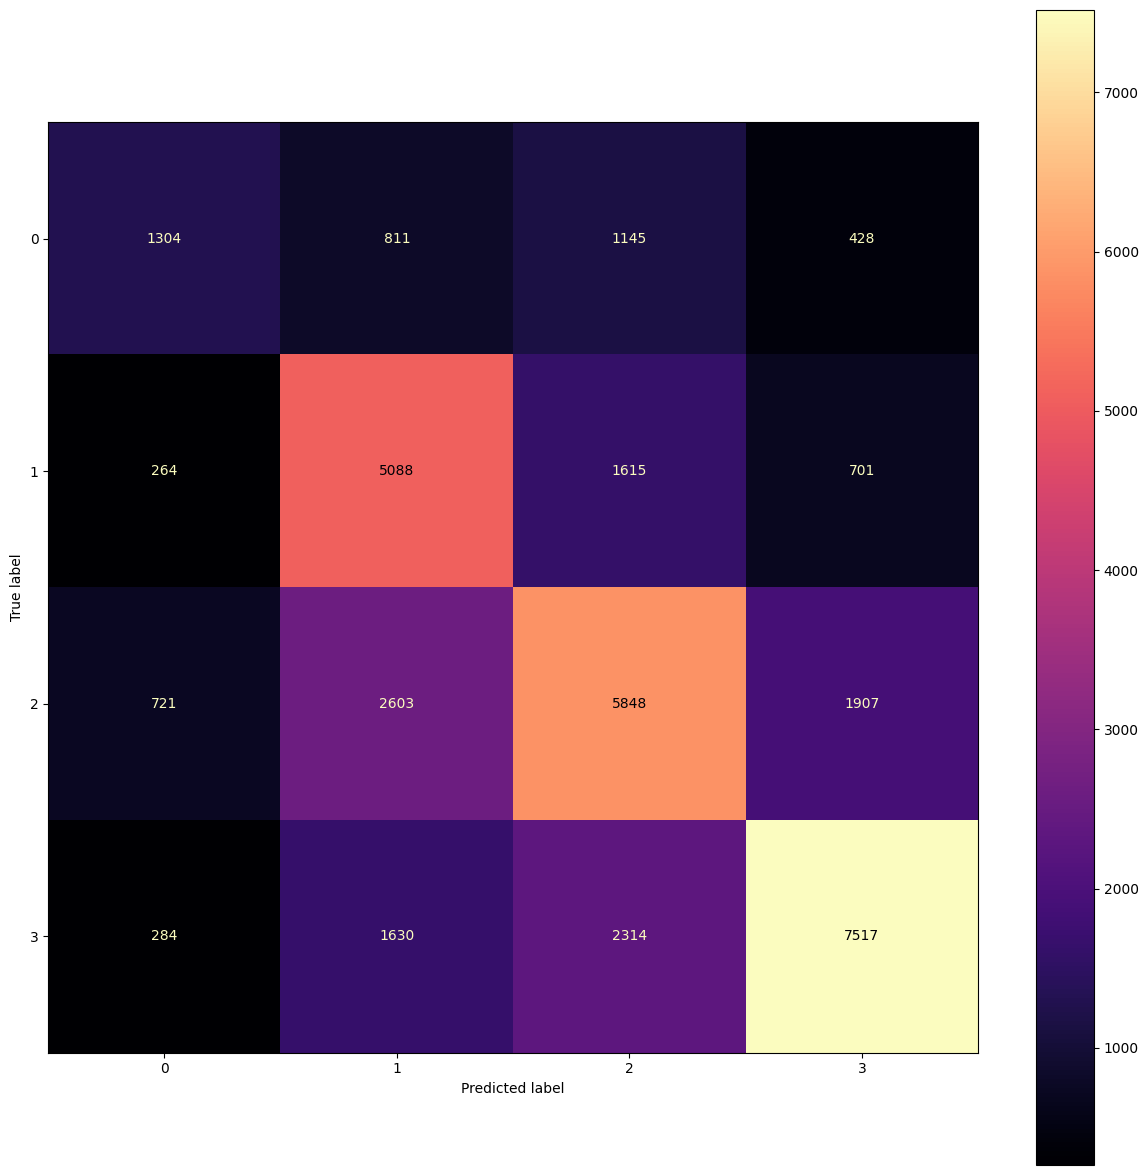

In [329]:
y_sent_predict = clf2.predict(X_embed_avg_test)
print(f"Score for Sentiments: {clf2.score(X_embed_avg_test, y_sent_test)}")
metrics(y_sent_test, y_sent_predict)
cmp = ConfusionMatrixDisplay(confusion_matrix(y_true=y_sent_test, y_pred=y_sent_predict))
fig, ax = plt.subplots(figsize=(15,15))
cmp.plot(ax=ax, cmap='magma')

In [330]:
parameters = {"activation":("identity", "logistic", "tanh", "relu"),"hidden_layer_sizes":((5,5),(5,10)), "solver":("adam","sgd")}
#currently 5 neurons then 5 neurons and 5 neurons then 10 neurons in the hidden layer
clfMLP = MLPClassifier(early_stopping=True,verbose=True, max_iter=100)
classifier = GridSearchCV(estimator=clfMLP, param_grid=parameters, n_jobs=-1)
skip=False
if(not skip):
    if (os.path.exists('models/new_split/MLP1GridCV_Wiki_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP1GridCV_Wiki_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        X_embed_avg_train, y_emo_train
        classifier = classifier.fit(X_embed_avg_train, y_emo_train)
        with open('models/new_split/MLP1GridCV_Wiki_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP1GridCV_Wiki_model_emb.pickle','rb')
        clf1 = pickle.load(pickle_in)

    if (os.path.exists('models/new_split/MLP2GridCV_Wiki_model_emb.pickle')):
        pickle_in = open('models/new_split/MLP2GridCV_Wiki_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
        print("pickle file used")
    else:
        classifier = classifier.fit(X_embed_avg_train,y_sent_train)
        with open('models/new_split/MLP2GridCV_Wiki_model_emb.pickle','wb') as f:
            pickle.dump(classifier, f)

        pickle_in = open('models/new_split/MLP2GridCV_Wiki_model_emb.pickle','rb')
        clf2 = pickle.load(pickle_in)
else:
    print("skipped")

pickle file used
pickle file used
